# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data.

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [1]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
    !pip install typeguard==2.13.3

Mounted at /content/drive
  Cloning https://github.com/joshuaspear/pymlrf.git to /tmp/pip-req-build-zl0g66hf
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/pymlrf.git /tmp/pip-req-build-zl0g66hf
  Resolved https://github.com/joshuaspear/pymlrf.git to commit 2e86313edd7900c1b5621b4e31368a36328b69f8
  Preparing metadata (setup.py) ... done
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20447 sha256=1b871409559693e8389930d93d865d2cc41c435f5ee5e7d58b1c52aaf50c5966
  Stored in directory: /tmp/pip-ephem-wheel-cache-7b7aax6b/wheels/b5/e9/53/587b30108dd50ceffb743ada10dd85037096182424fb2c907e
Successfully built pymlrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
  Cloning https://github.com/joshuaspear/comp0188_cw2_public.git to /tmp/pip-req-build-mxc_5pmk
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/comp0188_cw2_public.git /tmp/pip-req-build-mxc_5pmk
  Resol

Ignore the error:
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [57]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = False
print(project_options.debug)

True
False


In [58]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop
from sklearn.metrics import accuracy_score, confusion_matrix


In [4]:
print(train_dh.loc)

/content/drive/MyDrive/comp0188_2425/cw2/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [ ]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [59]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
print(type(train_nps))


<class 'dict'>


### EDA

EDA will be done on the training set

In [61]:
import pandas as pd
import os
import logging
import h5py
import matplotlib.pyplot as plt
import numpy as np
from comp0188_cw2.utils import to_greyscale
from comp0188_cw2.config import FILE_PATH, ROOT_PATH
import seaborn as sns

## Check data type and shape ##

In [ ]:
# print data types and shape of keys in train_nps dictionary
print(train_nps.keys())

for key in train_nps.keys():
    print(key, train_nps[key].shape)
    print(key, train_nps[key].dtype)


dict_keys(['actions', 'front_cam_ob', 'mount_cam_ob', 'terminals', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob'])
actions (25469, 4)
actions float16
front_cam_ob (25469, 224, 224)
front_cam_ob float16
mount_cam_ob (25469, 224, 224)
mount_cam_ob float16
terminals (25469,)
terminals int64
ee_cartesian_pos_ob (25469, 7)
ee_cartesian_pos_ob float16
ee_cartesian_vel_ob (25469, 6)
ee_cartesian_vel_ob float16
joint_pos_ob (25469, 2)
joint_pos_ob float16


In [ ]:
print(train_nps['actions'])

[[ 0.       0.       0.03072  1.     ]
 [ 0.       0.       0.03506  1.     ]
 [ 0.02853  0.       0.2      1.     ]
 ...
 [ 0.       0.      -0.       0.     ]
 [ 0.       0.      -0.       0.     ]
 [ 0.       0.      -0.       1.     ]]


## Print observation examples##

Index: 51
Actions: [ 0.      0.     -0.0936  1.    ]
Terminal State: 0
Position: [ 0.1439   -0.478     0.267     0.00238  -0.003254  0.988     0.1544  ]
Velocity: [-0.004543  0.013145 -0.1619    0.0418   -0.01059  -0.05487 ]
Joint Positions: [1.055 1.05 ]


Index: 53
Actions: [ 0.  0. -0.  0.]
Terminal State: 0
Position: [ 0.1434   -0.4773    0.2598    0.00224  -0.003609  0.9883    0.1542  ]
Velocity: [0. 0. 0. 0. 0. 0.]
Joint Positions: [1.03  1.025]


Index: 57
Actions: [ 0.  0. -0.  0.]
Terminal State: 0
Position: [ 0.1433   -0.4773    0.2593    0.002283 -0.003616  0.9883    0.1539  ]
Velocity: [0. 0. 0. 0. 0. 0.]
Joint Positions: [0.843 0.839]


Index: 61
Actions: [ 0.  0. -0.  0.]
Terminal State: 0
Position: [ 0.143    -0.4775    0.2593    0.002247 -0.003546  0.988     0.1542  ]
Velocity: [0. 0. 0. 0. 0. 0.]
Joint Positions: [0.669  0.6626]


Index: 65
Actions: [ 0.  0. -0.  0.]
Terminal State: 0
Position: [ 0.1431   -0.4775    0.2595    0.002237 -0.003447  0.9883    0.154   ]
Vel

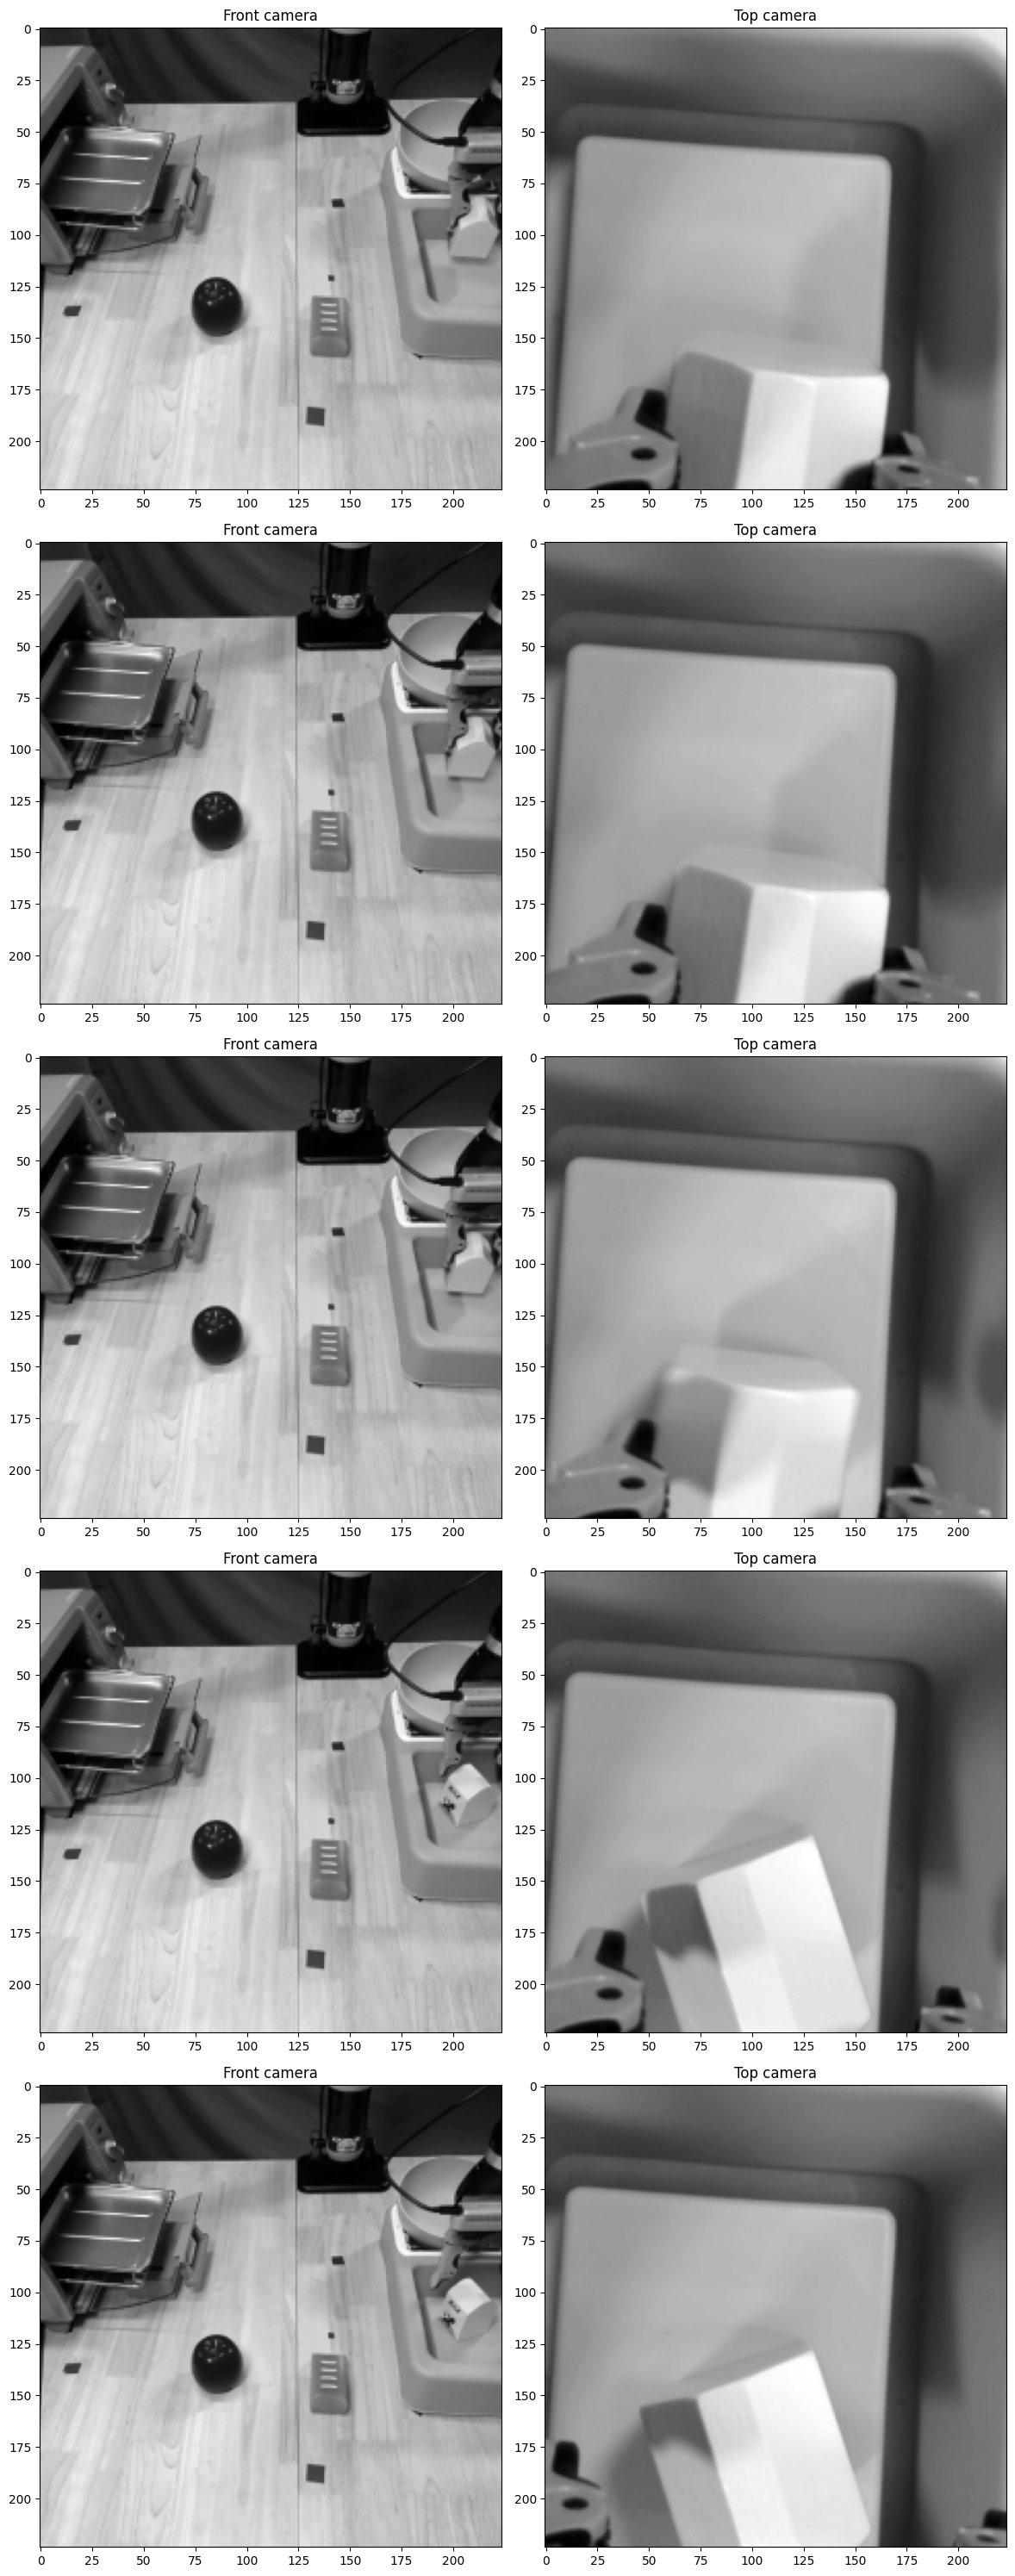

In [ ]:
# print observations from 5 indices
random_indices = [51,53,57,61,65] # these indices were selected to show how the open action works on the gripper

fig, axes = plt.subplots(5, 2, figsize=(12, 30))

for i, idx in enumerate(random_indices):
    img_front = train_nps["front_cam_ob"][idx]
    img_mount = train_nps["mount_cam_ob"][idx]


    axes[i, 0].imshow(img_front,cmap='gray')
    axes[i, 0].set_title("Front camera")
    axes[i, 1].imshow(img_mount,cmap='gray')
    axes[i, 1].set_title("Top camera")

    print(f"Index: {idx}")

    # Actions
    print("Actions:", train_nps["actions"][idx])

    # Terminal State
    print("Terminal State:", train_nps["terminals"][idx])

    # EE Position and Velocity
    print("Position:", train_nps["ee_cartesian_pos_ob"][idx])
    print("Velocity:", train_nps["ee_cartesian_vel_ob"][idx])

    # Joint Positions
    print("Joint Positions:", train_nps["joint_pos_ob"][idx])

    print("\n")

plt.tight_layout()
plt.show()

Index: 72
Actions: [0.  0.  0.2 1. ]
Terminal State: 0
Position: [ 0.143    -0.4773    0.2786    0.005062 -0.004635  0.989     0.1477  ]
Velocity: [ 0.00646 -0.0209   0.3464  -0.0946   0.02782  0.1206 ]
Joint Positions: [0.4004 0.3955]


Index: 73
Actions: [0.     0.     0.1522 1.    ]
Terminal State: 1
Position: [ 0.1428   -0.4773    0.285     0.0054   -0.004963  0.9893    0.1476  ]
Velocity: [ 0.0036  -0.01282  0.2642  -0.07404  0.02258  0.0941 ]
Joint Positions: [0.4004 0.3955]


Index: 74
Actions: [-0.04156  0.      -0.03723  1.     ]
Terminal State: 0
Position: [-0.0751  -0.2708   0.3066   0.00543 -0.01968  0.989    0.1481 ]
Velocity: [-0.0417     0.0003054 -0.0376     0.008965  -0.001904  -0.01191  ]
Joint Positions: [0.04312 0.03696]


Index: 75
Actions: [-0.1501  0.     -0.174   1.    ]
Terminal State: 0
Position: [-0.0751   -0.2708    0.3064    0.005447 -0.01968   0.989     0.1478  ]
Velocity: [-0.1501    0.002527 -0.1757    0.04236  -0.01227  -0.0578  ]
Joint Positions: [0.04

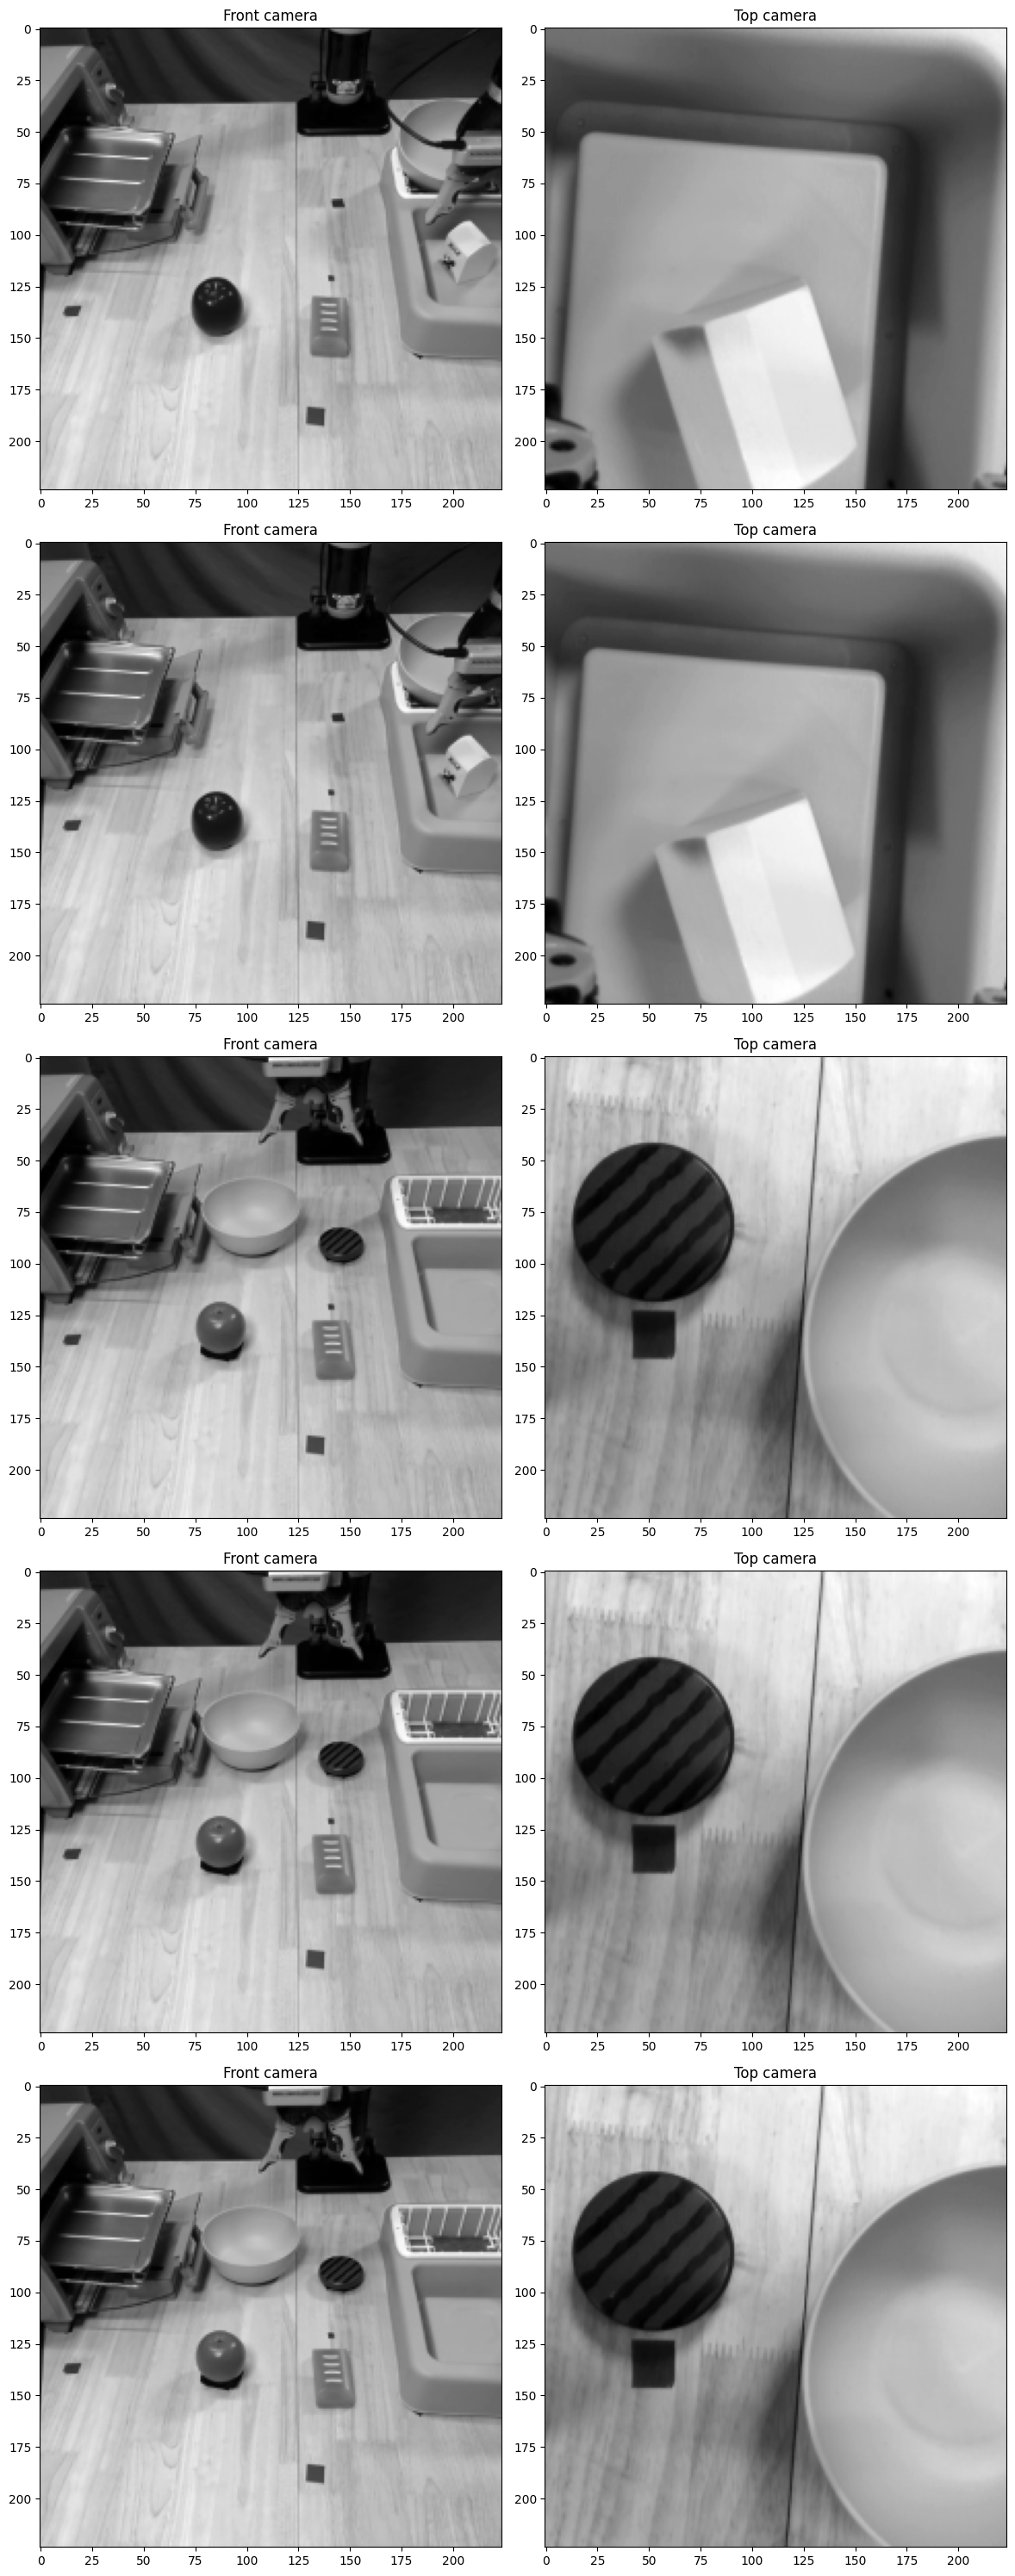

In [ ]:
# print observations from 5 indices
random_indices = [72,73,74,75,76] #helps me understand how episodes work. Epsidoe changes at 74.

fig, axes = plt.subplots(5, 2, figsize=(12, 30))

for i, idx in enumerate(random_indices):
    img_front = train_nps["front_cam_ob"][idx]
    img_mount = train_nps["mount_cam_ob"][idx]


    axes[i, 0].imshow(img_front,cmap='gray')
    axes[i, 0].set_title("Front camera")
    axes[i, 1].imshow(img_mount,cmap='gray')
    axes[i, 1].set_title("Top camera")

    print(f"Index: {idx}")

    # Actions
    print("Actions:", train_nps["actions"][idx])

    # Terminal State
    print("Terminal State:", train_nps["terminals"][idx])

    # EE Position and Velocity
    print("Position:", train_nps["ee_cartesian_pos_ob"][idx])
    print("Velocity:", train_nps["ee_cartesian_vel_ob"][idx])

    # Joint Positions
    print("Joint Positions:", train_nps["joint_pos_ob"][idx])

    print("\n")

plt.tight_layout()
plt.show()

## Missing value analysis ##

In [ ]:
import numpy as np

def missing_values(data):
    for key, value in data.items():
        if np.isnan(value).any():
            print(f"Missing values in {key}")
        else:
            print(f"No missing values in {key}")

missing_values(train_nps)

No missing values in actions
No missing values in front_cam_ob
No missing values in mount_cam_ob
No missing values in terminals
No missing values in ee_cartesian_pos_ob
No missing values in ee_cartesian_vel_ob
No missing values in joint_pos_ob


## Distribution of Numerical variables##

In [ ]:
# min max median and mean
for key in ["actions", "terminals", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]:
    data = train_nps[key]

    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    median_val = np.median(data, axis=0)
    mean_val = np.mean(data, axis=0)

    print(f"Statistics for {key}:")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Median: {median_val}")
    print(f"Mean: {mean_val}")
    print()

    #standardize "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"

Statistics for actions:
Min: [-0.2 -0.2 -0.2  0. ]
Max: [0.2 0.2 0.2 2. ]
Median: [0. 0. 0. 1.]
Mean: [-1.773e-03 -7.524e-04 -7.172e-03  1.008e+00]

Statistics for terminals:
Min: 0
Max: 1
Median: 0.0
Mean: 0.017786328477757275

Statistics for ee_cartesian_pos_ob:
Min: [-0.4407  -0.6636   0.1569  -0.06793 -0.093    0.977    0.0474 ]
Max: [ 0.22    -0.2524   0.4014   0.03787  0.07275  0.998    0.1956 ]
Median: [-0.08636 -0.4395   0.266    0.00528 -0.0163   0.991    0.1292 ]
Mean: [-0.0796   -0.428     0.2666    0.004375 -0.0159    0.991     0.1274  ]

Statistics for ee_cartesian_vel_ob:
Min: [ -1.153  -0.687  -0.458  -4.312 -11.88   -5.438]
Max: [ 1.156   0.3928  0.404   3.352  12.25    5.16  ]
Median: [0. 0. 0. 0. 0. 0.]
Mean: [-0.0006886 -0.002449  -0.00844    0.001617  -0.01225    0.003397 ]

Statistics for joint_pos_ob:
Min: [-0.001232 -0.001232]
Max: [1.412 1.38 ]
Median: [0.9165 0.8945]
Mean: [0.8843 0.8667]



## Gripper analysis##

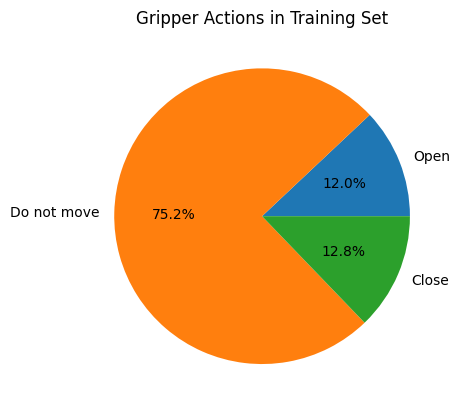

In [ ]:
gripper_actions = train_nps['actions'][:, 3]

unique, counts = np.unique(gripper_actions, return_counts=True)

fig, ax = plt.subplots()

ax.pie(counts, labels=['Open', 'Do not move', 'Close'], autopct='%1.1f%%')

ax.set_title('Gripper Actions in Training Set')
plt.show()

## Image analysis and pixel distribution##

In [ ]:
first_image = train_nps["front_cam_ob"][random_indices[0]]

print(f"First image as a vector:\n {first_image.flatten()}")

# the image is grayscale

First image as a vector:
 [ 33.28  32.88  32.28 ... 141.9  137.9  141.2 ]


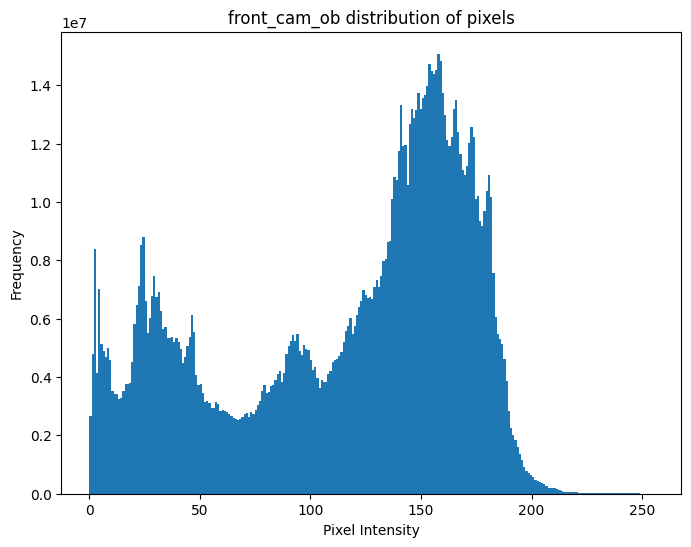

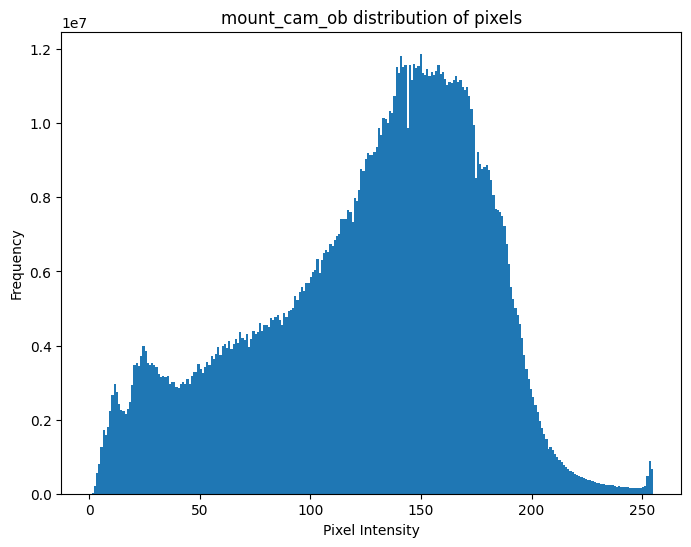

In [ ]:
def pixel_distribution(image_data,title):

  plt.figure(figsize=(8, 6))
  plt.hist(image_data.ravel(), bins=256, range=(0, 255))
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.title(title)
front_cam_ob = train_nps.get("front_cam_ob")
mount_cam_ob = train_nps.get("mount_cam_ob")

pixel_distribution(front_cam_ob, "front_cam_ob distribution of pixels")
pixel_distribution(mount_cam_ob, "mount_cam_ob distribution of pixels")

In [ ]:
# delete to free up space
del front_cam_ob
del mount_cam_ob

### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output.

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [62]:
# ******* INSERT YOUR CODE HERE *******
from sklearn.preprocessing import StandardScaler
from PIL import Image


# Initialize
pos_scaler = StandardScaler()
vel_scaler = StandardScaler()
joint_scaler = StandardScaler()


# Fit standard scalers to numerical data
pos_scaler.fit(train_nps['ee_cartesian_pos_ob'])
vel_scaler.fit(train_nps['ee_cartesian_vel_ob'])
joint_scaler.fit(train_nps['joint_pos_ob'])


global_transforms = {
    "front_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),

        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])

    ]),
    "mount_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),

        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])

    ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: torch.tensor(pos_scaler.transform(x.reshape(1, -1)).squeeze()),
    "ee_cartesian_vel_ob": lambda x: torch.tensor(vel_scaler.transform(x.reshape(1, -1)).squeeze()),
    "joint_pos_ob": lambda x: torch.tensor(joint_scaler.transform(x.reshape(1, -1)).squeeze())
}

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

**_actions_**: This is the response variable. No preprocessing has been done on the actions variable. The actions variable is an array of 4 elements. The first 3 elements represent position co-ordinates. The 4th element is an indicator that can take on 3 values:


*   0: open gripper
*   1: hold the gripper position
*   2: close gripper

There is no reason to scale or perform preprocessing on the position co-ordinates since this might alter the value and make it unintuitive after modelling.

There is also no reason to do preprocessing on the gripper indicator variable (4th column) as it is in an appropriate form for modelling - i.e., already as an indicator.

There are also no missing values that need to be treated.

EDA on the gripper showed that there is evidence of class imbalanace - "do not move" action was more prevalent than other actions. However, to keep things simpler, this was not addressed in preprocessing




**_front_cam_ob_**: This explanatory variable is an image, hence preprocessing was executed suitable for images. The variable was converted from a numpy array to a PIL image object as torchvision transforms work better on PIL images. Distribution of pixel values showed that pixel values were skewed. Standardization was done as it helps to stabilize training and improve model performance. Standardizing with a mean of 0.5 and standard deviation of 0.5 ensures that the data is in the range [-1,1]. There were no missing values that needed to be treated. Outliers were not checked for, as these images come directly from robot motion episodes and checking for outliers would have been difficult. The image was converted to greyscale and as a tensor.


**_mount_cam_ob_**: the same preprocessing was done as in _front_cam_ob_. The data was converted to a PIL image, then standardized, as EDA revelaed pixel values were skewed. The image was then converted to grayscale and then to a tensor. There was no reason to apply any other preprocessing.


**_ee_cartesian_pos_ob_**: This is a numerical array that stores 7 values. EDA revealed that numerical explanatory variables operate on different numerical scales - hence a standard scaler was used to normalize the data and ensure that no single value disproportionately impacted the prediction. There were no missing values. Given the nature of the task (replicating robot movements), there was no need to check for outliers - this would be proven wrong if the robot exhibited eratic movemets when recording - however for simplicity, I assumed that all positional values were correct. The values were converted to tensors.


**_ee_cartesian_vel_ob_**: This is a numerical array that stores 5 values. Similarly, standard scaling was applied to this variable to normalize the values. In theory this should lead to better model outputs. There were no missing values that needed to be handled. The values were converted to tensors.


**_joint_pos_ob_**: this is a numerical array that stores 2 values. Similarly, standard scaling was applied to this variable to normalize the values. In theory this should lead to better model outputs. There were no missing values that needed to be handled. The values were converted to tensors.

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which:
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [63]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

ANSWER:

The composite loss function is reasonable. MSE loss is an apt loss function for the positional co-ordinates, since position is a continuous variable - so MSE is a measure of the "distance" between the model's prediction of position and the actual position. Cross entropy loss is reasonable for the gripper action, as it is commonly used in classification problems. Prediction of gripper is a classification problem: 0 represents open, 1 represents hold (do not move), 2 represents close.

The composite loss equally weights these 2 losses. This indicates that our model should aim to minimize the overall loss and we do not prioritize higher accuracy in position over gripper action (or vice versa). The composite loss equally balances objectives of predicting position as well as gripper action.

In [64]:

pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [65]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.5117, device='cuda:0', dtype=torch.float16)


In [66]:
# create directory for storing outputs
os.makedirs('./output', exist_ok=True)


In [67]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:24<00:00,  4.70it/s]
INFO:cw2_logger:epoch 1	 training loss : 72.0625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.72412109375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:26<00:00,  4.59it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.63525390625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.6396484375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:27<00:00,  4.55it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.576171875
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.62451171875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:24<00:00,  4.69it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.53271484375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.57666015625 
INFO:cw2_logger:Running tr

In [ ]:
#save model
def save_model(model, model_path):
  torch.save(model.state_dict(), model_path)
  print(f"Model saved to {model_path}")
save_model(model, "/content/drive/MyDrive/comp0188_2425/cw2/saved_model.pt")

Model saved to /content/drive/MyDrive/comp0188_2425/cw2/saved_model.pt


In [ ]:
#load model
model = Baseline1(image_encoder, obs_encoder, dense)

model.load_state_dict(torch.load('/content/drive/MyDrive/comp0188_2425/cw2/saved_model.pt'))

if torch.cuda.is_available():
    model.cuda()

model.eval()

<ipython-input-44-5806cb4287d4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/comp0188_2425/cw2/saved_model.pt'))

Baseline1(
  (image_encoder): JointCNNEncoder(
    (_cnn): CNN(
      (module_list): ModuleList(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU()
        (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (_dense): MLP(
      (module_lst): ModuleList(
        (0): DenseBlock(
          (linear): Linear(in_features=25088, out_features=256, bias=True)
        )
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (_flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (obs_

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

ANSWER:

Based on the analysis below, the appropriate number of epochs is 10. The model below was trained on 30 epochs. The model below also dropped the learning rate from the baseline (as learning was unstable in the baseline model - as shown by the erratic jumps in losses on the validation set).

Losses logged below were used as the criteria for selecting epochs. The objective is to find the number of epochs until the model begins overfitting.

The overall loss on the validation set begins to increase after epoch 10 - indicating that overfitting occurs after this epoch. The validation loss at epoch 10 was 0.5986. It was consistently higher on the epochs after this.

Furthermore, 10 epochs provides a good balance between training for enough epochs and being overly burdensome on computational and time resources.

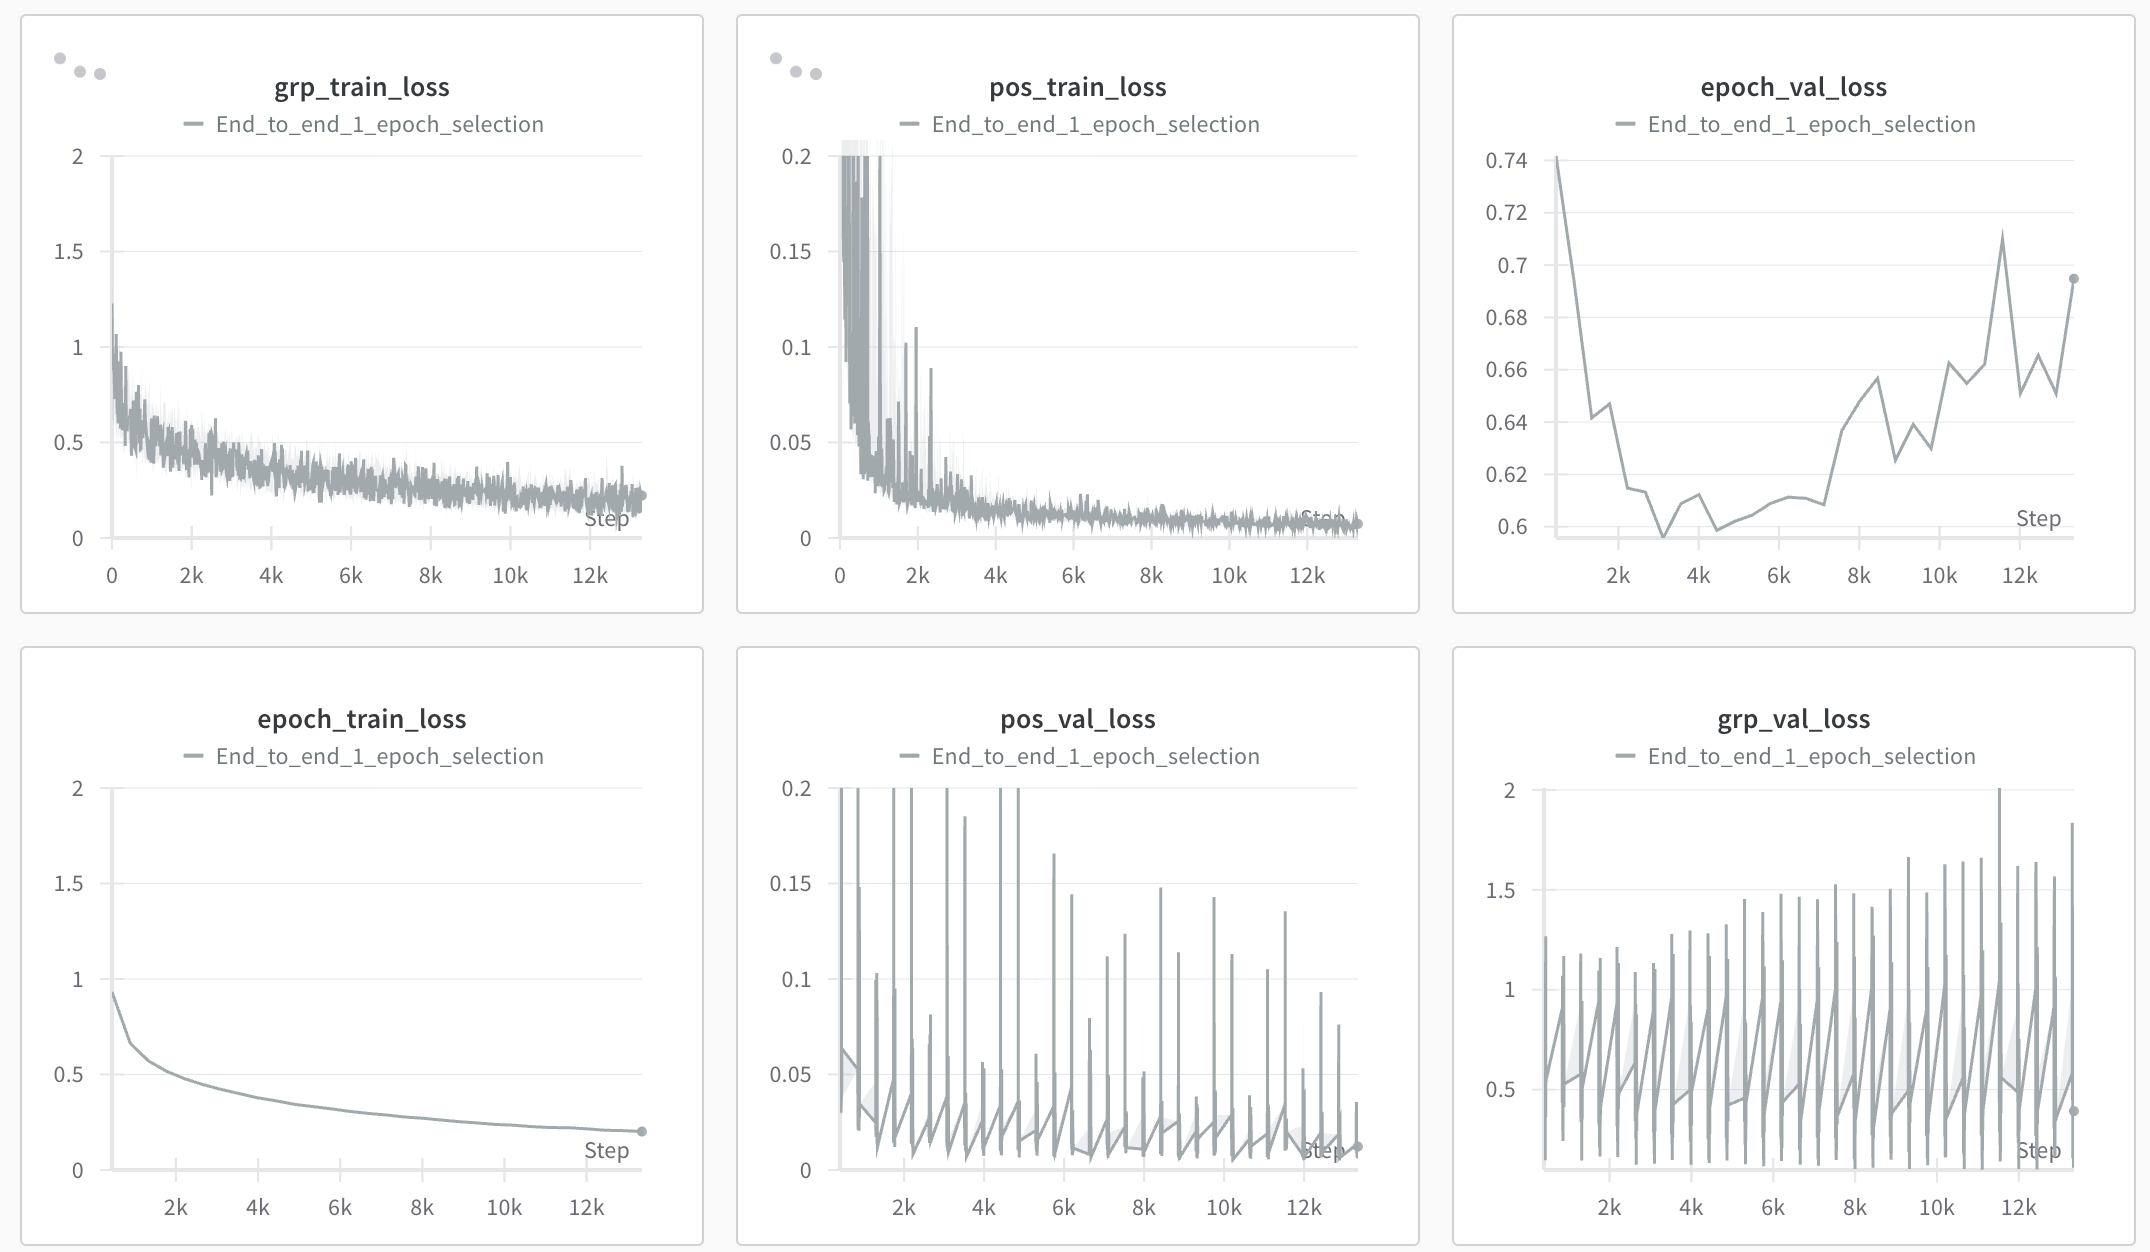

In [ ]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.00001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.6094, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=30, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
    #preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_epoch_selection"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

def save_model(model_path="/content/drive/MyDrive/comp0188_2425/cw2/saved_model.pt"):
  torch.save(model.state_dict(), model_path)
  print(f"Model saved to {model_path}")

orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()


wandb: Currently logged in as: sachinnaidoo09 (sachinnaidoo09-ucl). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 30
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:23<00:00,  4.79it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.93212890625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.74169921875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:21<00:00,  4.90it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.6630859375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.6943359375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:23<00:00,  4.78it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.57080078125
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.6416015625 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:23<00:00,  4.76it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.51611328125
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.64697265625 
INFO:cw2_logger:Runn

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

Below Code should be run using model trained under 1b.i.

Performance on Gripper in Training Set

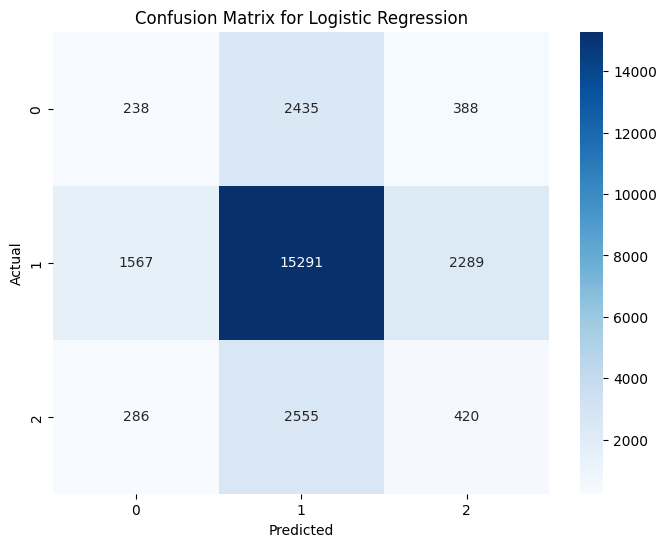

Overall Accuracy: 0.63
Class-wise Accuracies:
Class 0: 0.08
Class 1: 0.80
Class 2: 0.13


In [68]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

Performance on Gripper in Validation Set

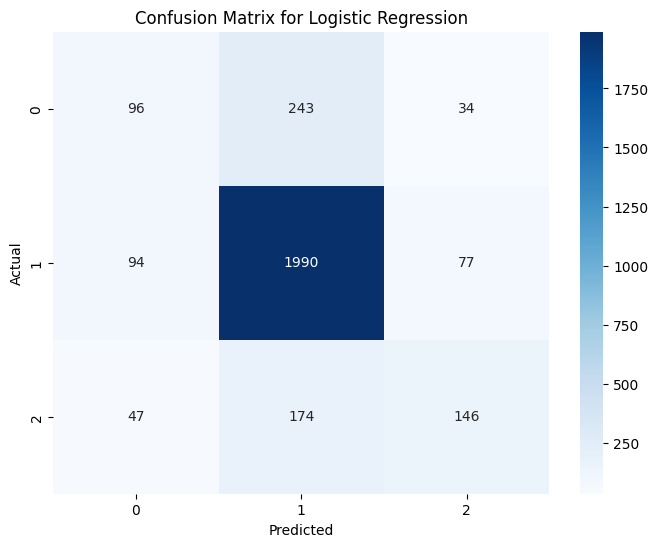

Overall Accuracy: 0.77
Class-wise Accuracies:
Class 0: 0.26
Class 1: 0.92
Class 2: 0.40


In [69]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

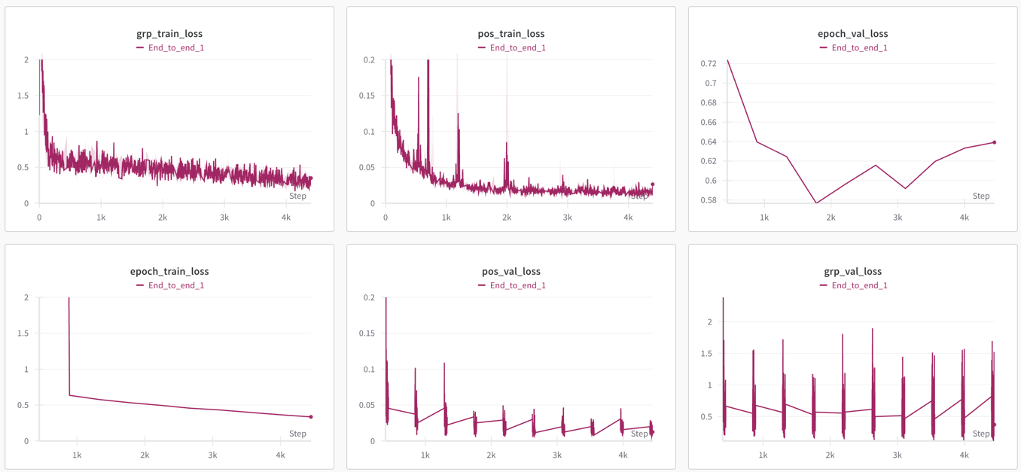

The 6 wandb graphs above represent performance of the baseline model. They will be used as metrics to evaluate model performance.

### Training Loss Graphs ###

*epoch_train_loss:* starts quite high in the first epoch but then decreases smoothly to a value of 0.3352. It is encouraging to see loss decrease smoothly without any spikes. This, alone, indicates stability in the training process. The model achieved an overall loss of 0.3352 on the training set by the 10th epoch indicating that the model is performing reasonably well on training data.

*grp_train_loss* and *pos_train_loss*: these graphs individually display losses for the 2 predictions: gripper action and position. Loss functions behind the graphs are different (cross entropy for gripper and MSE for position). Encourgaingly, both graphs show a stable downward slop indicating stability in the training process as the model converges. However, there are spikes in the *pos_train_loss* graph which may be evidence that training is unstable.

### Validation Loss Graphs ###

*epoch_val_loss*: the same stability from the training loss graphs is not shown in the validation loss graphs. Losses on the validation set are erratic and steady convergence does not occur. By the 4th epoch, a minimum of 0.5767 occurs, however by the final epoch, loss on the validation is around 0.64. This indicates that either: the number of epochs is too high and the model overfits (unlikely), or the learning rate is too high and the model overshoots a minimum. This has likely occurred - hence a lower learning will be used to improve the model and help support a steady decrease in the validation loss towards a minimum.

*grp_val_loss* and *pos_val_loss*: these graphs show spikes. Furthermore, there is no general downward slop of the losses in these graphs indicating lack of convergence.

### Overfitting ###
By the 10th epoch, the training loss was 0.335 whereas the validation loss was 0.639 (nearly twice as high as the training loss). This is evidence that overfitting has occurred. Overfitting occurs when the model performs well on seen data but does not generalize well to unseen data. The high disparity between training and validation loss indicates that the model has learnt the training data too well and cannot generalize to validation data.

Gripper training loss was 0.35 and validation loss was 0.37.
Position training loss was 0.02648 and validation loss was 0.0125.
This indicates overfitting of the position prediction is what drives overall overfitting (there is not as big a difference in the gripper losses across training and validation).


### Confusion Matrices and Accuracy ###

The Gripper prediction is a classification task, hence we are able to plot confusion matrices and calculate accuracy of the prediction. Accuracy is defined as the number_of_correct_predictions divided by total_number_of_predictions. This keeps accuracy scores simple - however a better accuracy score may take into account the proximity of a wrong prediction - e.g., if the true label is 0, then a prediction of 1 is "less wrong" than a prediction of 2.

Overall accuracy on the training set was 0.63 and accuracy on the validation set was 0.77. These are both better than random guesses (which would have a 0.33 accuracy). This is evidence that the model has learnt from the underlying data. However, an area of concern is that class-wise accuracies vary substantially. When predicting class 1, the model has high accuracy, however has very low accuracy when predicting class 0 and class 2. This is likely due to class imabalance we saw in EDA (most of the gripper actions are "hold" or "do not move") - hence the model has developed a bias towards this class, with low accuracy on the minority class. A way to solve this is by using a weighted random sampler or oversampling the minority classes (or undersamping the majority class).

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should:
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


### Unstable Learning ###

The validation loss graphs show evidence of instability as validation losses do not converge to a minimum. By the 4th epoch, a minimum loss value of 0.5767 is reached, however by the 10th epoch, the loss increases to 0.639. It is likely caused by a high learning rate - hence learning rate will be decreased in the improved model. It could potentially be caused by overfitting - where the model converges to a minimum quickly (by the 4th epoch) but then overfits to the training data. Lack of convergence on the validation set is a model failure.


### Overfitting ###

As discussed in performance evaluation, overfitting occurs - as shown by the large disparity between the training loss and validation loss (0.335 and 0.639 respectively). This overfitting is driven by the position prediction variable, as there is not much difference in loss between gripper loss on the training and validation set (0.35 and 0.37 respectively). This indicates that the model performs well on seen data but does not generalize well to unseen data. The validation loss graphs display erratic behaviour. The problem is quite significant as loses on the validation data area nearly twice as high as the training data.

The high learning rate may have partially contributed to erratic behavior on the validation set as the model overshoots a minimum. Overfitting likely occurs due to lack of regularization or an overly complex model. Techniques such as weight decay may improve the model's ability to generalize.

In terms of dataset coverage, EDA revealed a class imbalance in gripper actions - 75% of the gripper actions were "no move." This could potentially lead to a biased model with poor performance on the minority classes.
Furthermore, the disparity in the training and validation losses could simply be due to the nature of the task - the underlying data has been split into "episodes", with each episode representing robot movement. Each episode is sequence of clips. Episodes are split into a training, validation and test set. If the validation set contains an episode where the robot does something very different to the training set, it might not perform well (e.g., if the robot picks up white plates in training, but in validation, picks up a black mug, the prediction may not be good). This is an issue with all tasks that involve data splitting - however it is more prevalent with episode-level splitting as an entire episode in validation can be unrelated to episodes in training.

### Gripper Prediction - Failure on Minority Classes ###
Gripper prediction was, overall, better than random chance. However, this high overall accuracy was driven by high accuracy on the majority class (class 1). The model developed a bias towards this class due to the class imbalance in the training data. Model performance on the minority classes were low. Training accuracy on class 0 and 2 were 0.08 and 0.13 respectively (both are significantly lower than random chance (0.33). Validation accuracy on class 0 and 2 were 0.26 and 0.4 - which is still fairly low. Of the 373 true labels in the validation set for class 0, the model failed on 277 predictions. Similarly, of the 367 true labels of class 2 in the validation set, the model failed on 221 predictions. As stated, accuracy on class 1 was high - correctly predicting 1990 of 2161 class 1 labels. This is an indication that the model has developed a bias towards class 1 predictions on the gripper. This is due to a class imbalance in the training data (from EDA 75.2% of observations were from class 1). The model overfits to the majority class and performs poorly on minority classes. Furthermore, the accuracy metric might be misleading as the model is good at identifying the majority class and can do so with high accuracy - but really poor at identifying the minority class (i.e., a simple model that only predicts class 1 would achieve high accuracy)

### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),


        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))


        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128,
        actvton = nn.ReLU()
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [ 256,256],
    output_dim = 128,
    actvton = nn.ReLU()

)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6,
    actvton = nn.ReLU()

)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model_final = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)
# ******* INSERT YOUR CODE HERE - END *******

In [ ]:
torch.manual_seed(1)
model_final.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.00001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model_final.__repr__()


if exp_kwargs["half_precision"]:
    model_final = model_final.half()
optimizer = torch.optim.Adam(
    model_final.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04, weight_decay = 0.01
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model_final= model_final.cuda()
            with torch.autocast(device_type="cuda"):
                res = model_final(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model_final(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model_final = model_final.cuda()
            res = model_final(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model_final(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.1963, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model_final, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_improvement_final"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:23<00:00,  4.74it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.63134765625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.5654296875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:21<00:00,  4.87it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.498046875
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.48974609375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:24<00:00,  4.70it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.422119140625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.442626953125 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:23<00:00,  4.79it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.384521484375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.426513671875 
INFO:cw2_logger:

In [ ]:
save_model(model_final,"/content/drive/MyDrive/comp0188_2425/cw2/saved_model_final.pt")

Model saved to /content/drive/MyDrive/comp0188_2425/cw2/saved_model_final.pt


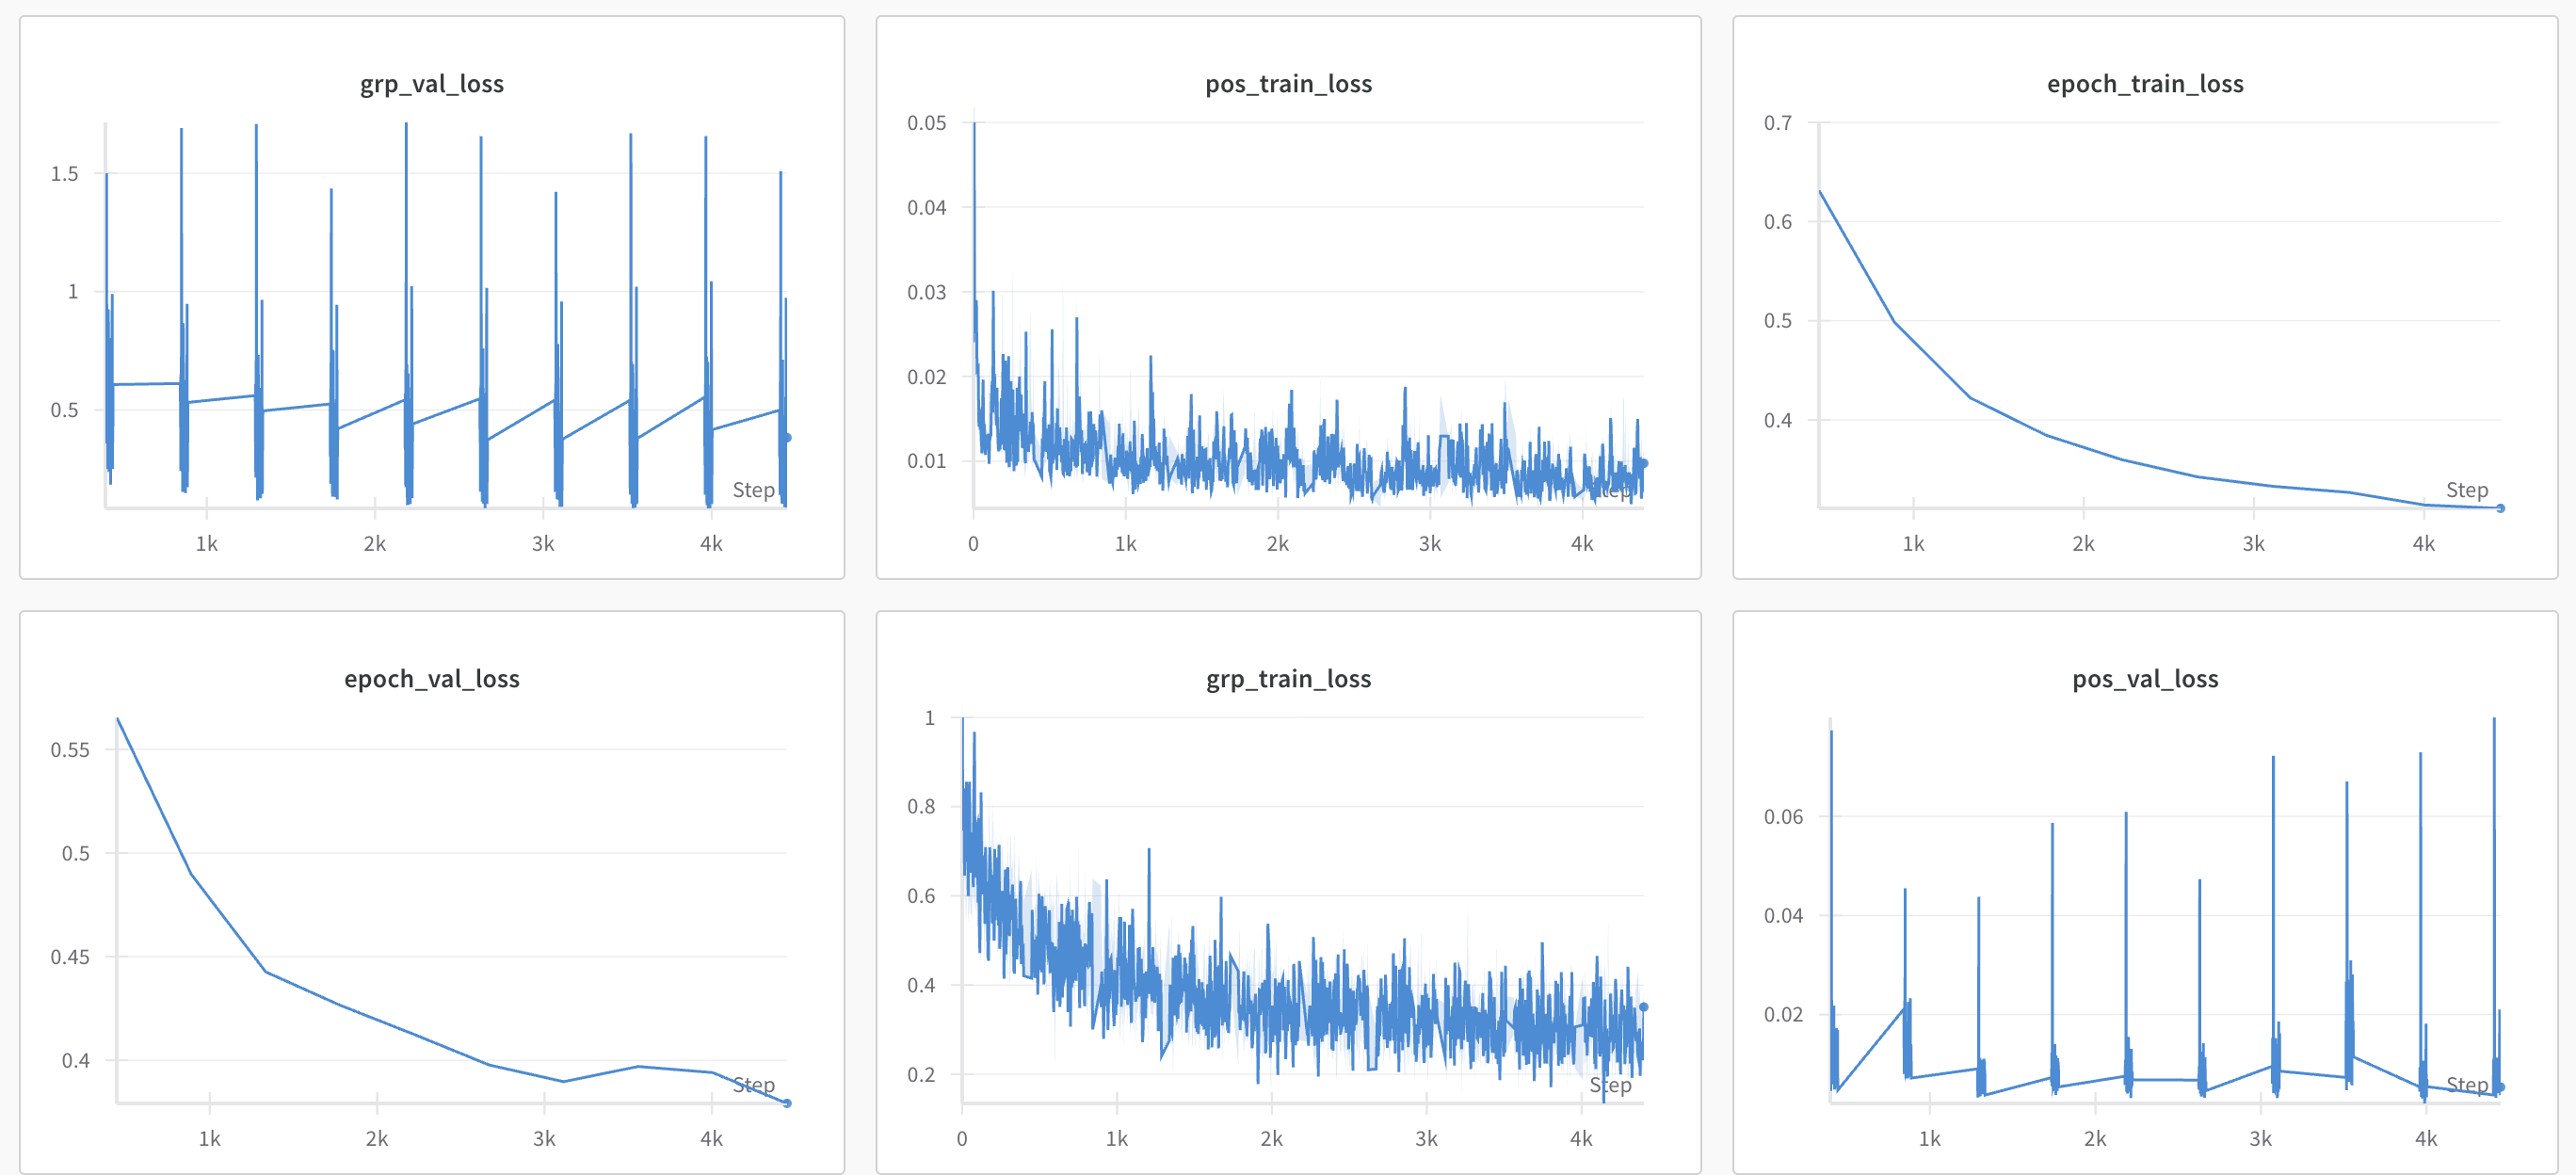

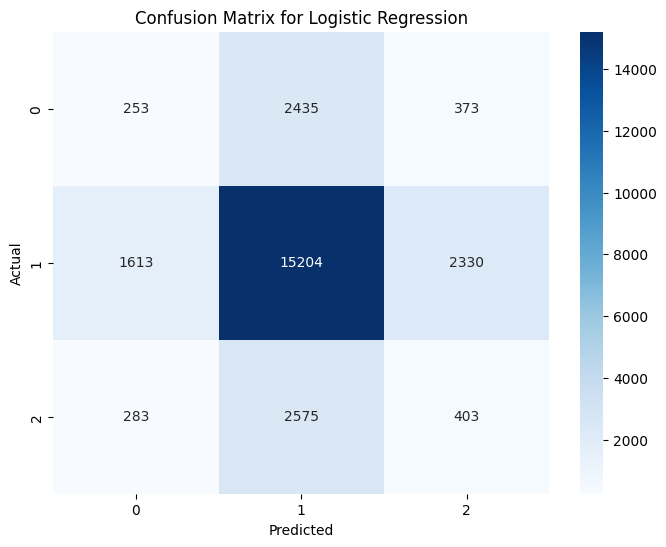

Overall Accuracy: 0.62
Class-wise Accuracies:
Class 0: 0.08
Class 1: 0.79
Class 2: 0.12


In [ ]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

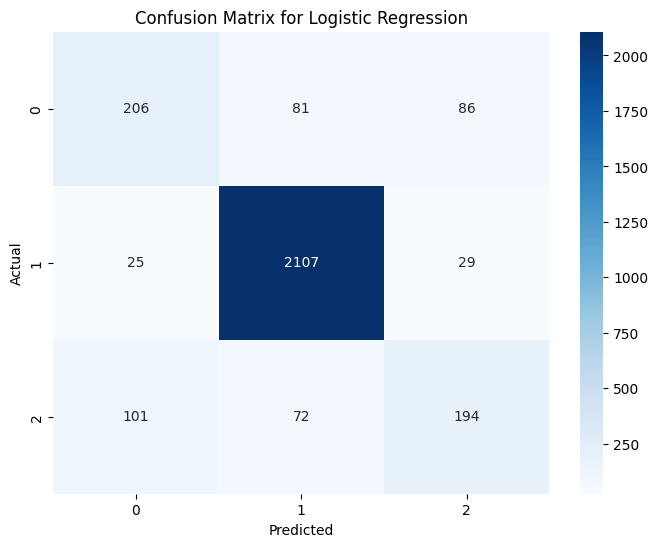

Overall Accuracy: 0.86
Class-wise Accuracies:
Class 0: 0.55
Class 1: 0.98
Class 2: 0.53


In [ ]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

The tuned model was better than the Baseline model. There was a slight improvement on training loss (0.311 vs 0.335 on the Baseline). However, there was a significant improvement on the validation set (0.379 vs 0.639 on the Baseline). There was a steady decrease in validation losses - showing that, as the model trained, model weights were updated with more stability as the model converged to a solution. It is also clear that overfitting did not occur as there is not a large disparity between training losses and losses on the validation set.

Looking at individual losses on the position predictions and the gripper prediction, the model's improvement was driven by better prediction of position. The gripper prediction was approximately the same as the baseline model.

Although gripper prediction training accuracy decreased slightly from the Baseline (0.63 to 0.62), validation accuracy increased signficantly from 0.77 to 0.86. Encouragingly, predictions on the minority classes were much higher than the Baseline Model (from 0.26 to 0.55 on class 0 and from 0.4 to 0.53 for class 2). This indicates that predictions on the minority classes are now better than random (0.33). However, accuracy on the minority classes are still signficantly lower than the majority class (0.98) indicating that the model is still biased towards the majority class.

Overall this model is better than the Baseline due to lower losses.

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example:
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### **Description**
Learning rate has been droppped by 100-fold (from 0.001 to 0.00001). Different learning rates were experimented with before reaching this rate.

##### **Justification**
From baseline model results, we saw the validation loss graph showed an erratic pattern - i.e., it did not steadily converge to a minimum. The high learning rate caused unstable training, as model weights would have oscillated and not converged to a minimum solution. The high learning rate caused the model to overshoot a minimum. A high learning rate can sometimes lead to fast convergence, however in this case, it caused unstable learning. Hence, the learning rate was decreased to allow the model to make smaller adjustments to parameters - allowing it to converge steadily towards a minimum and not overshoot the solution.

##### **Conclusion**
The decreased learning rate was successful in stabilizing losses on the validation set. This confirms the hypothesis that unstable learning was caused by a high learning rate. There was a distinct downwards trend in the slope of the graph as the model updates parameters each epoch to converge  towards a minimum. The problem of overshooting a minimum value has been solved. Additionally, the validation loss under this model is 0.599 after 10 epochs. This is lower than the 0.639 validation loss under the baseline model - which indicates this model is slightly better at generalizing to unseen data.

Accuracy marginally improved from 0.63 to 0.65 on the training set and 0.77 to 0.78 on the validation set.
However the objective of the change was not directly to improve accuracy, but rather to stabilize model training.

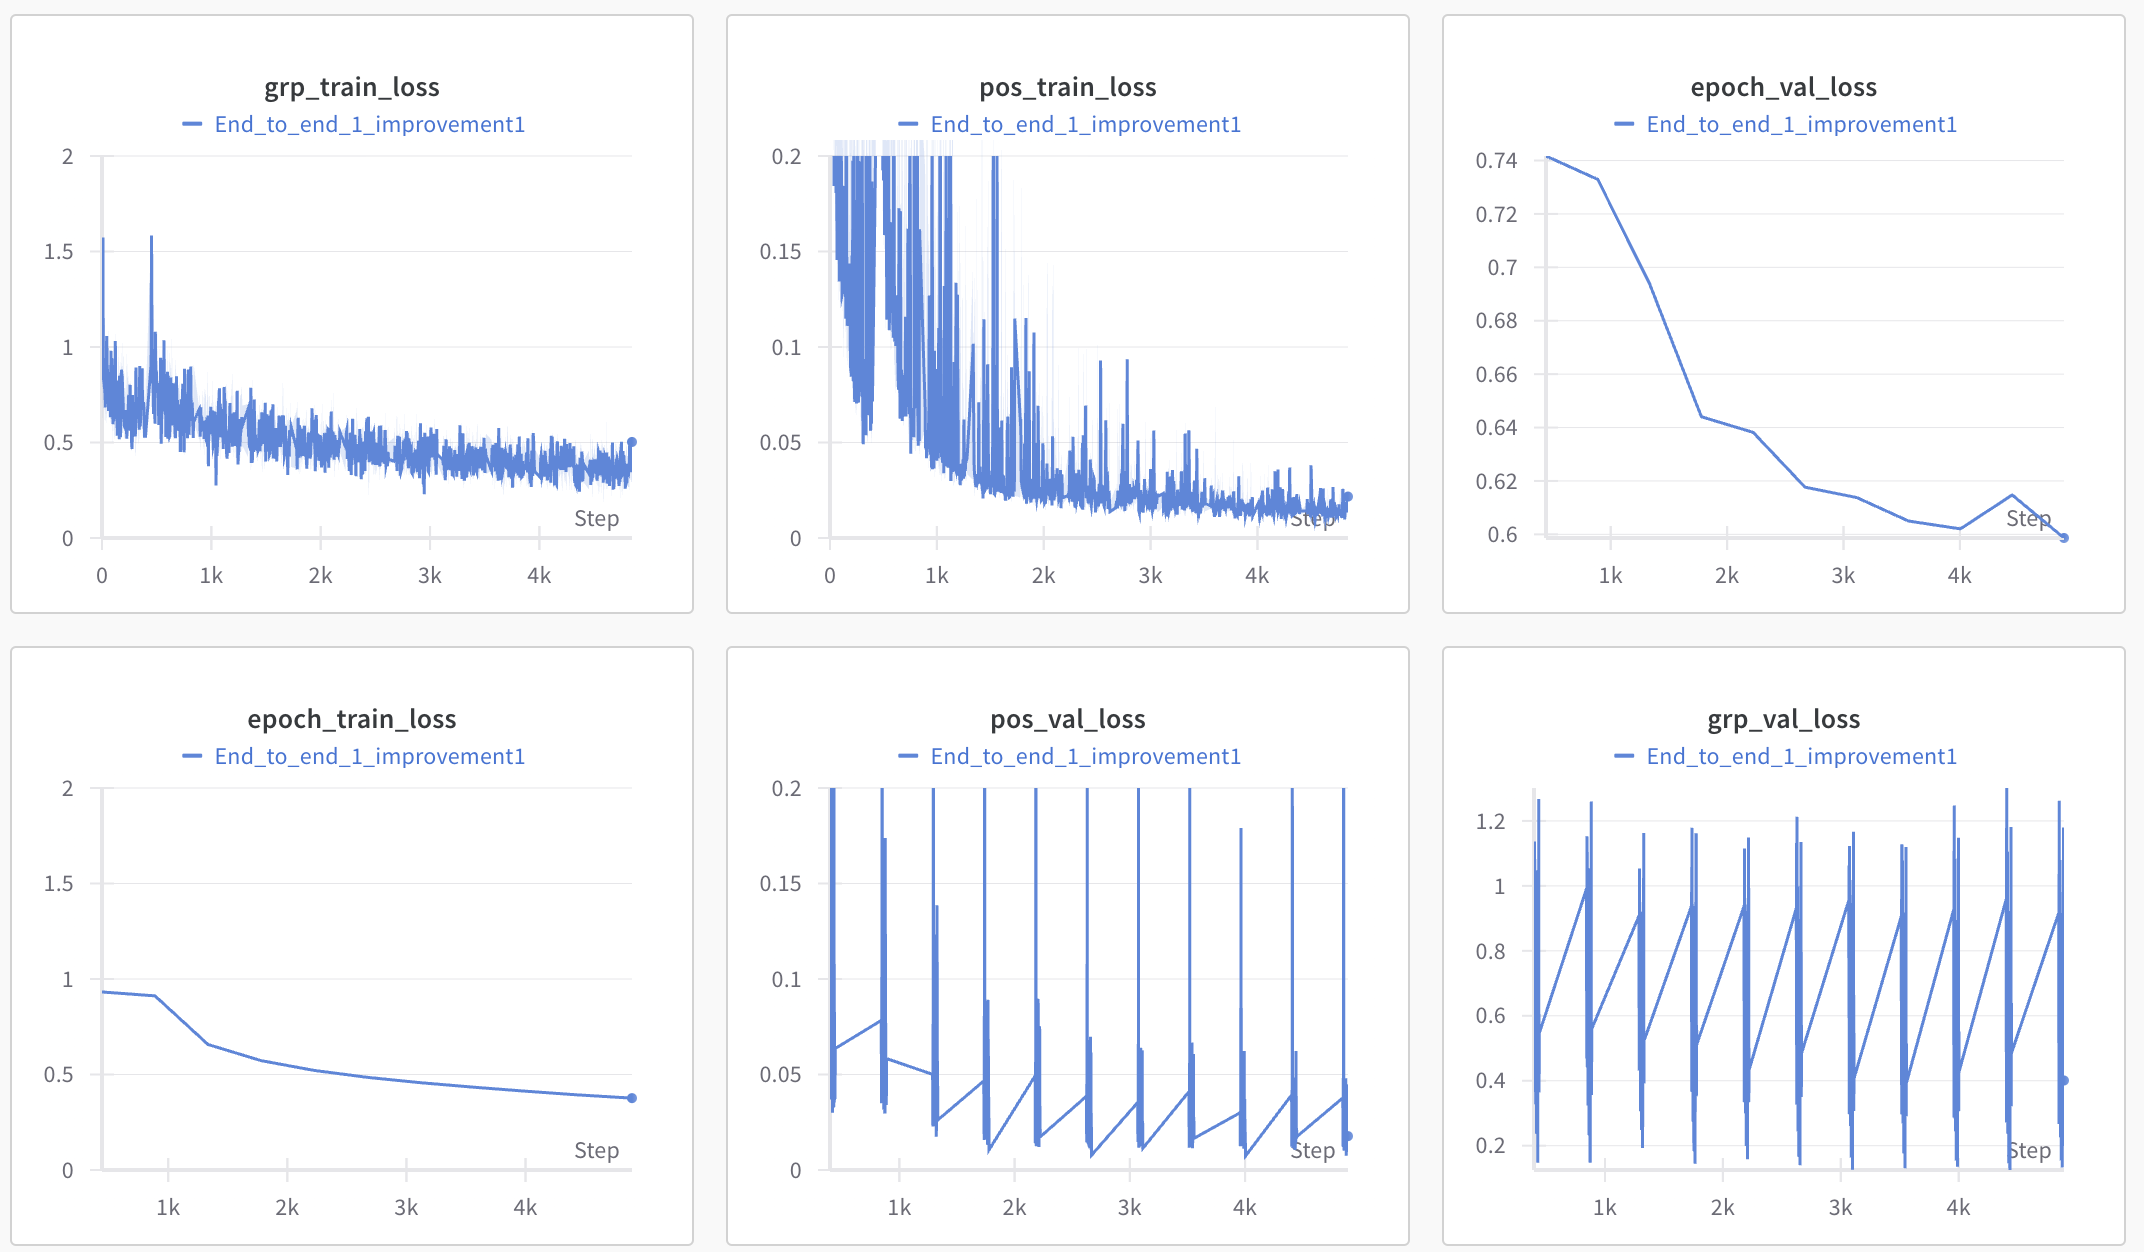

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model2 = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [ ]:
torch.manual_seed(1)
model2.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.00001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model2.__repr__()


if exp_kwargs["half_precision"]:
    model2 = model2.half()
optimizer = torch.optim.Adam(
    model2.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model2 = model2.cuda()
            with torch.autocast(device_type="cuda"):
                res = model2(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model2(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model2 = model2.cuda()
            res = model2(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model2(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.5117, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model2, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_improvement1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"



orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:20<00:00,  4.97it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.91162109375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.73291015625 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:19<00:00,  4.98it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.6572265625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.69384765625 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:19<00:00,  5.00it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.57275390625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.64404296875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:19<00:00,  5.01it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.521484375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.63818359375 
INFO:cw2_logger:Runn

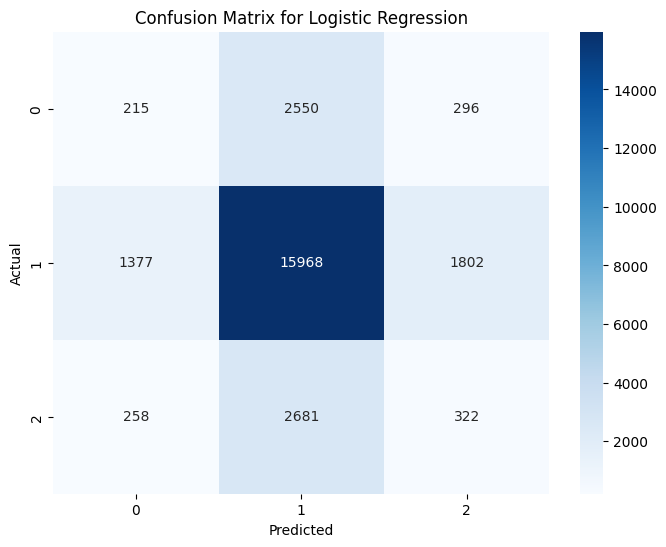

Overall Accuracy: 0.65
Class-wise Accuracies:
Class 0: 0.07
Class 1: 0.83
Class 2: 0.10


In [ ]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

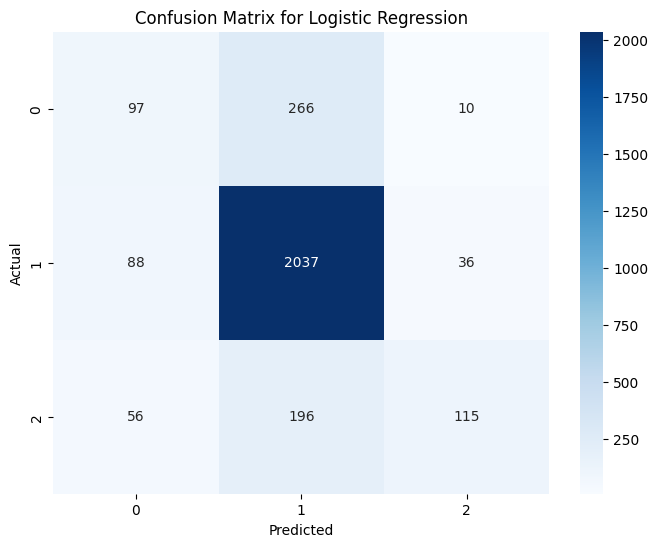

Overall Accuracy: 0.78
Class-wise Accuracies:
Class 0: 0.26
Class 1: 0.94
Class 2: 0.31


In [ ]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

In [ ]:
save_model(model2,'/content/drive/MyDrive/comp0188_2425/cw2/saved_model_improvement1.pt')

Model saved to /content/drive/MyDrive/comp0188_2425/cw2/saved_model_improvement1.pt


#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### **Description**
L2 regularization (weight-decay of 0.01) was used to address the problem of overfitting and improve generalization

##### **Justification**
We saw in the baseline model that losses on the validation set were nearly twice as high as losses on the training set. This indicates that overfitting occurred on the baseline model. Weight decay operates by adding a penalty term to the loss function and encourages a model with smaller weights, while still aiming to reduce loss. This improves the generalization ability of the model, improves stability and prevents overfitting. Adding weight decay to the optimizer achieves a balance between minimizing the original loss and keeping the model's weights small. We would expect a rise in training loss, but a decrease in validation loss. Models with smaller weights also support stability in training, as models with larger weights can produce predictions that are more sensitive to changes in input data.

##### **Conclusion**
As expected, overall training loss increased to. 0.491 (it was 0.335 on the Baseline). However, importantly, there was a decrease in validation loss to 0.559 (from 0.639 on the Baseline model). This indicates that the model is better at generalizing to unseen data. Interestingly, this model exhibits more stable learning (despite a higher learning rate of 0.001 used in the Baseline) - there were no fluctuations in validation loss as seen on the Baseline. This is due to the model developing smaller weights which are less likely to cause fluctuations in predictions.

Accuracy was higher - increasing from 0.63 to 0.69 on the training set and 0.77 to 0.78 on the validation set. However, class-wise accuracy is still low on class 0 and class 1 (0.02 and 0.08 respectively on training set and 0.18 and 0.44 respectively on the validation set). This is evidence that, although weight decay was successful in reducing overall validation losses, it was not successful in address bias on gripper predicting and overfitting predictions to class 1 - other techniques like oversampling would have to be used.

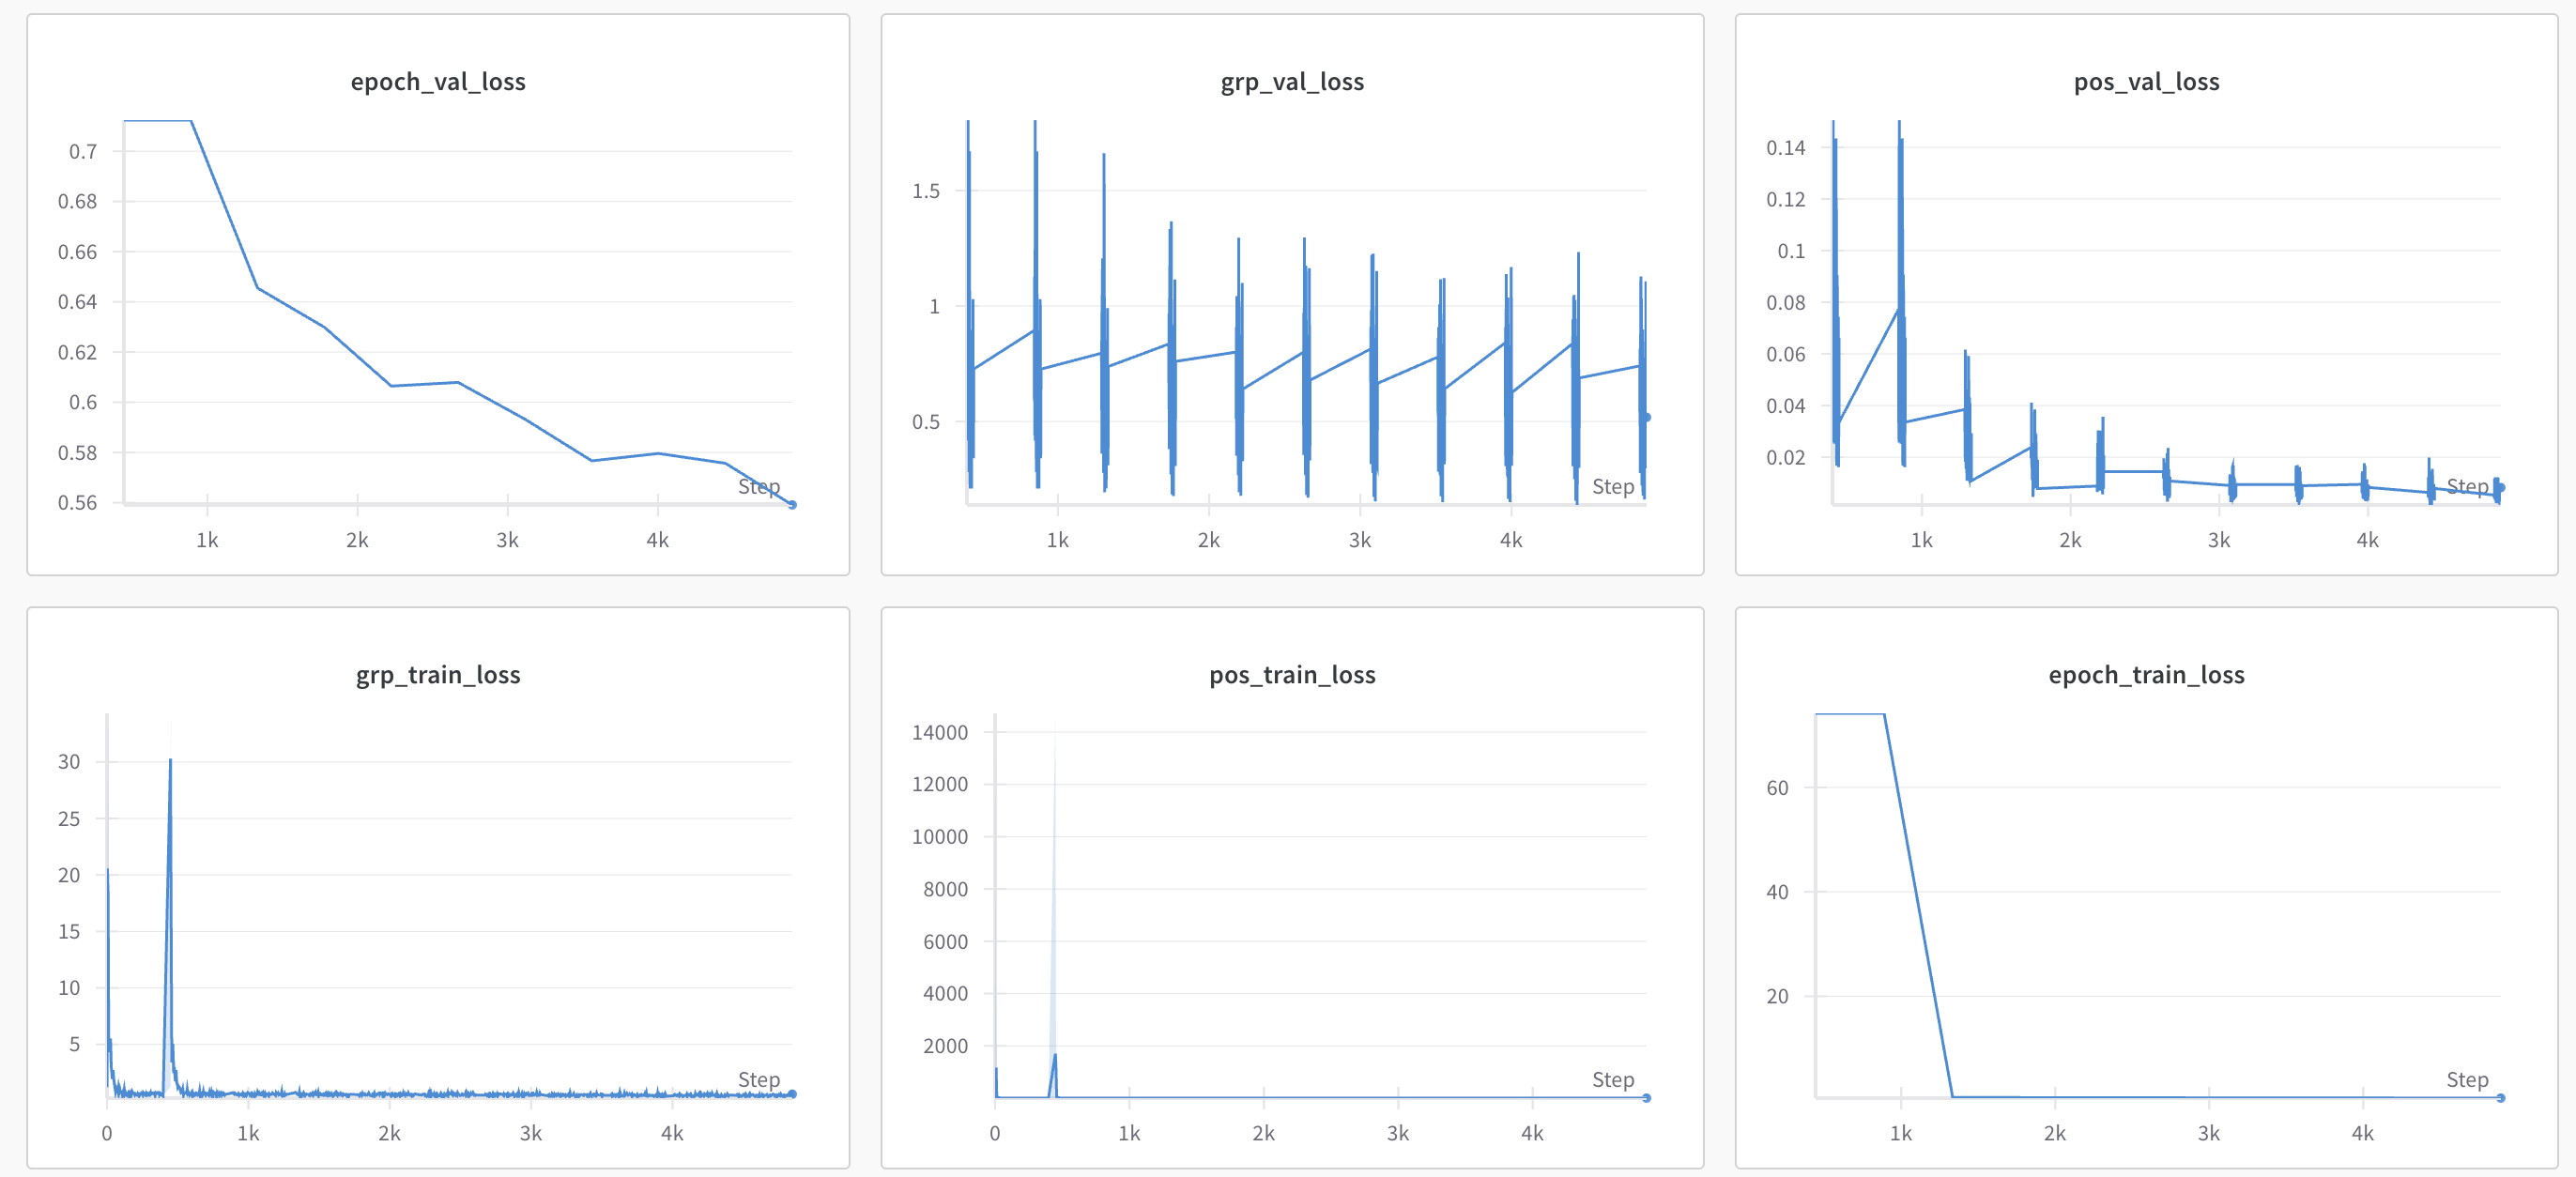

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),


        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model3 = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [ ]:
torch.manual_seed(1)
model3.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model3.__repr__()


if exp_kwargs["half_precision"]:
    model3 = model3.half()
optimizer = torch.optim.Adam(
    model3.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04, weight_decay = 0.01
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model3 = model3.cuda()
            with torch.autocast(device_type="cuda"):
                res = model3(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model3(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model3 = model3.cuda()
            res = model3(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model3(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.5117, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model3, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_improvement2"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"



orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

wandb: Currently logged in as: sachinnaidoo09 (sachinnaidoo09-ucl). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:43<00:00,  3.86it/s]
INFO:cw2_logger:epoch 1	 training loss : 74.1875
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.71240234375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:20<00:00,  4.95it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.64501953125
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.6455078125 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:21<00:00,  4.88it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.60302734375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.6298828125 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:21<00:00,  4.90it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.580078125
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.6064453125 
INFO:cw2_logger:Running trai

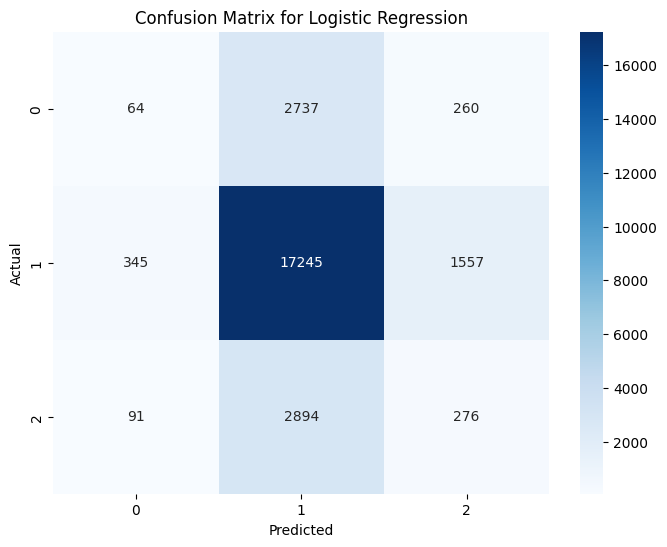

Overall Accuracy: 0.69
Class-wise Accuracies:
Class 0: 0.02
Class 1: 0.90
Class 2: 0.08


In [ ]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

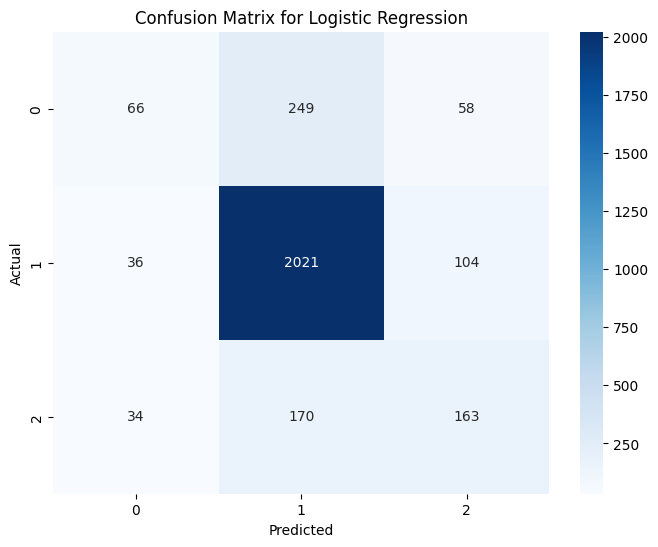

Overall Accuracy: 0.78
Class-wise Accuracies:
Class 0: 0.18
Class 1: 0.94
Class 2: 0.44


In [ ]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### **Description**
ReLU activation functions are used in the MLP

##### **Justification**
The MLP code is specified here: comp0188_cw2.models.MLP. The code has an optional parameter for activation function (called "actvton"). No activation function was used in the provided Baseline model, hence a linear transformation is applied between hidden layers. The MLP in the baseline is therefore just a sequence of linear transformations. ReLU activation functions introduce non-linearity just allows the network to learn more complex, non-linear relationships between outputs and inputs. They are essential to help the model learn complex patterns from the data. There was no explicit evidence from the Baseline run to use ReLU activation functions, however using non-linear activation functions is a generally-used principle in machine learning tasks and helps the model learn non-linear relationships between variables.

##### **Conclusion**
Results from the model run were encouraging. Training loss significantly decreased to 0.0567 (from 0.335 in the Baseline) - approximately a 6-fold decrease. Lower losses were expected as the model can learn non-linear patterns between input and outputs. The significant decrease in training loss also indicates that there are non-linear relationships between inputs and outputs in this given problem. The validation loss data was also encouraging - reaching a minimum of 0.334 (which is much lower than the Baseline validation loss of 0.639). It seems like there was evidence of overfitting, since by the 10th epoch, validation loss increased to 0.549. This is still lower than the Baseline validation loss, but higher than the minimum validation loss of 0.334. This issue could be caused by the learning rate from the baseline being too high - and the model overshoots a minimum value. Overfitting has occurred in this case where training losses are very low but validation losses are considerably higher. By using a lower learning rate (from experiment 1), more stable learning should occur, in theory. Nontheless, using ReLU activation functions had a dramatic improvement on the Baseline model.

The model's improved predictive ability was shown on the gripper accuracy for the validation set. Validation accuracy increased from 0.77 on the baseline to 0.86. Furthermore, class-wise accuracies, although prevalent, were not as severe. Class 0 and class 2 had accuracies of 0.56 and 0.51 respectively on the validation set - this is better than random chance (0.33), although still significantly lower than class 1 accuracy - 0.97.

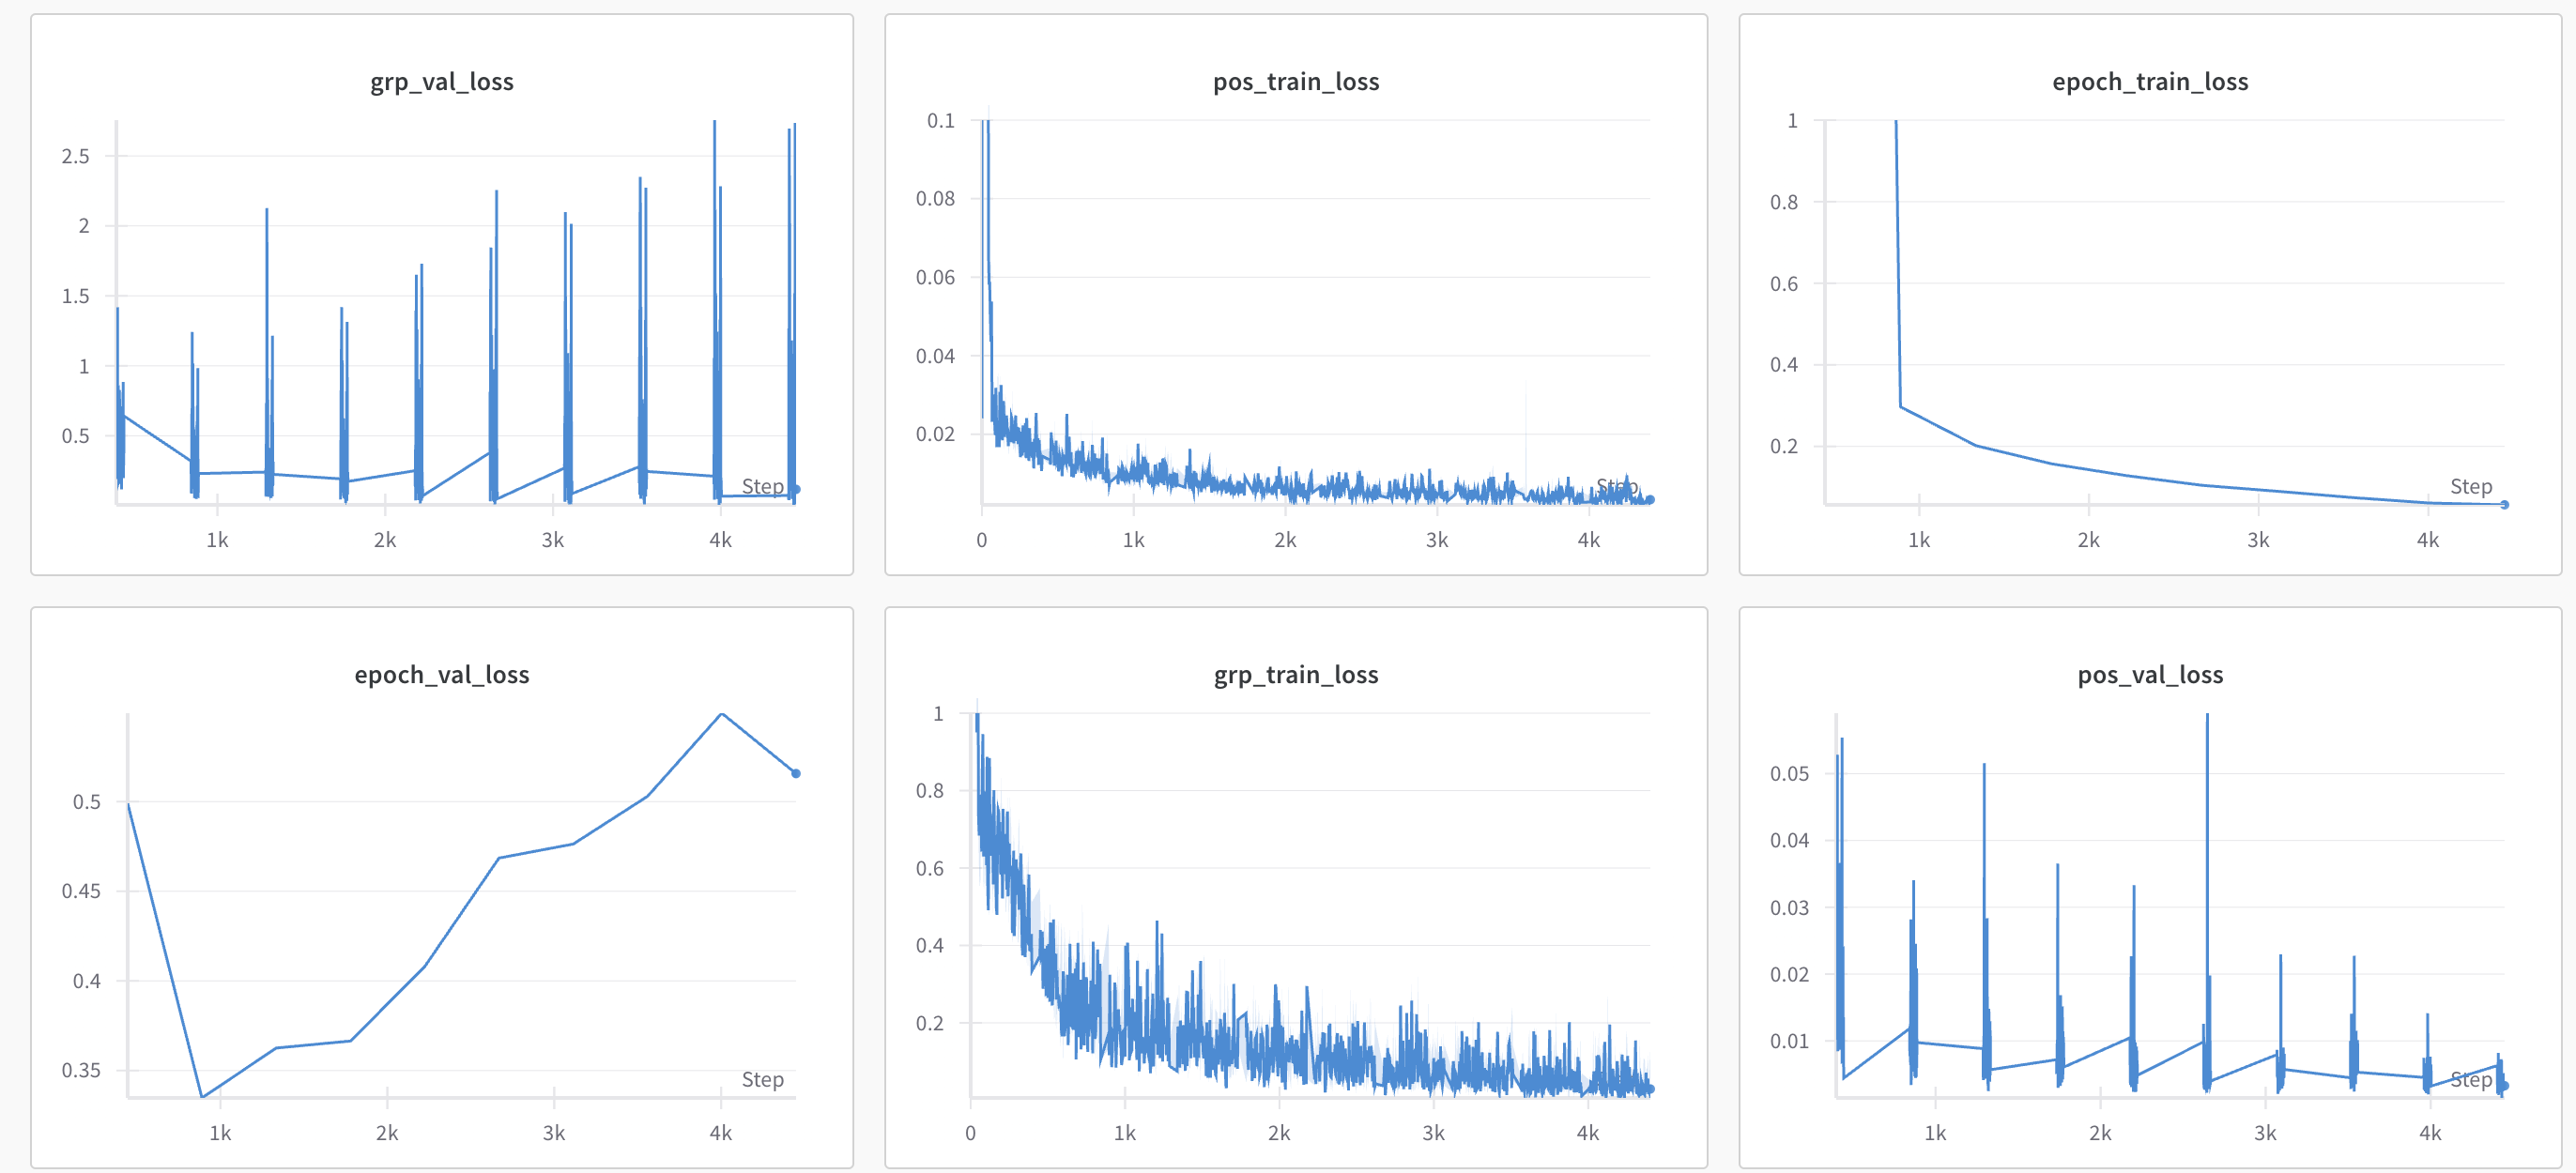

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),


        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))


        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128,
        actvton = nn.ReLU()
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [ 256,256],
    output_dim = 128,
    actvton = nn.ReLU()

)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6,
    actvton = nn.ReLU()

)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model4 = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [ ]:
torch.manual_seed(1)
model4.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model4.__repr__()


if exp_kwargs["half_precision"]:
    model4 = model4.half()
optimizer = torch.optim.Adam(
    model4.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model4 = model4.cuda()
            with torch.autocast(device_type="cuda"):
                res = model4(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model4(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model4 = model4.cuda()
            res = model4(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model4(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 2, 224, 224])
torch.Size([64, 15])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.1963, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model4, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_improvement3"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:38<00:00,  4.03it/s]
INFO:cw2_logger:epoch 1	 training loss : 12.5234375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.4990234375 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:21<00:00,  4.89it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.297119140625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.334716796875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [02:06<00:00,  3.14it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.2017822265625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.362548828125 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [01:45<00:00,  3.77it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.1573486328125
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.366455078125 
INFO:cw2_logg

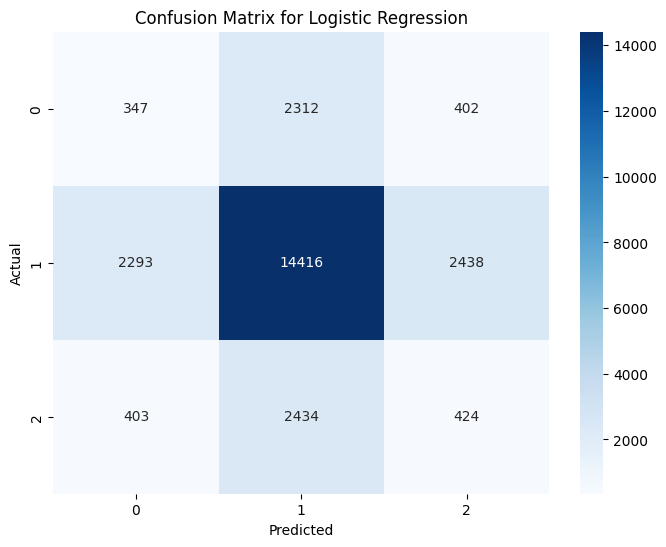

Overall Accuracy: 0.60
Class-wise Accuracies:
Class 0: 0.11
Class 1: 0.75
Class 2: 0.13


In [ ]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

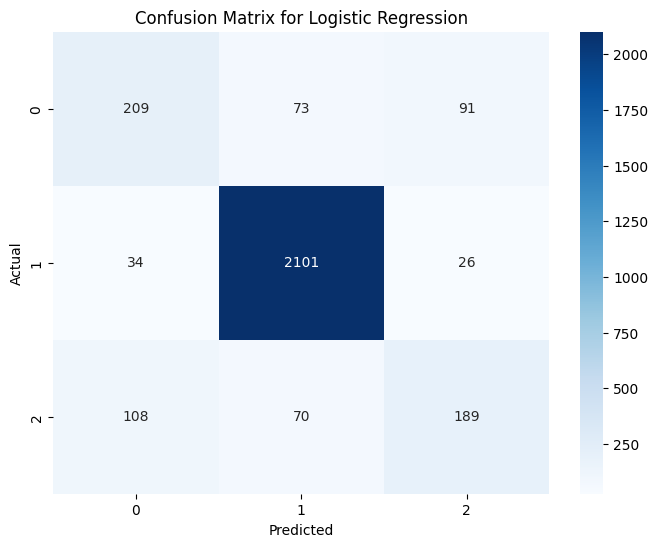

Overall Accuracy: 0.86
Class-wise Accuracies:
Class 0: 0.56
Class 1: 0.97
Class 2: 0.51


In [ ]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

DESCRIPTION OF METHODOLOGY: I will be training separate VAE models for each of the two images in the input data

In [13]:
# ******* INSERT YOUR CODE HERE *******
batch_size = 32

# data loader for VAE
train_dataset_vae_front = NpDictDataset(
       array_dict=train_nps,
       transform_lkp=global_transforms,
       dep_vars=[],
       indep_vars=["front_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )

val_dataset_vae_front  = NpDictDataset(
       array_dict=val_nps,
       transform_lkp=global_transforms,
       dep_vars=[],
       indep_vars=["front_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )
def custom_collate(batch):
    data = [item.input["front_cam_ob"] for item in batch]
    return torch.stack(data), torch.empty(len(data))

train_dataloader_vae_front  = DataLoader(
       train_dataset_vae_front,
       shuffle=True,
       batch_size=batch_size,
       collate_fn=custom_collate
   )

val_dataloader_vae_front  = DataLoader(
       val_dataset_vae_front,
       shuffle=False,
       batch_size=batch_size,
       collate_fn=custom_collate

   )





# ******* INSERT YOUR CODE HERE - END *******

In [14]:
# shape of train dataset vae
for x in train_dataloader_vae_front:
    print(x[0].shape)
    break

torch.Size([32, 1, 224, 224])


In [15]:
# VAE architecture
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
from torchsummary import summary

class VAE(nn.Module):
    def __init__(self, image_size=224, latent_dim=3):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim


        # Encoder for front and mount camera images
        # stride helps with processing and computational issues
        self.image_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )


        # Calculate flattened size
        self._img_feat_size = 256 * (image_size // 16) * (image_size // 16)


        # Latent space
        self.fc_mu = nn.Linear(self._img_feat_size , latent_dim)
        self.fc_logvar = nn.Linear(self._img_feat_size , latent_dim)

        # Decoder
        self.decoder_linear = nn.Linear(latent_dim, self._img_feat_size )

        # Image decoder
        self.image_decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh() #TanH since the standardization precprocessing causes image to be in range [-1,1]
        )



    def encode(self, x_img):

        img_features = self.image_encoder(x_img)
        img_features = img_features.view(img_features.size(0), -1)
        mu = self.fc_mu(img_features)
        logvar = self.fc_logvar(img_features)
        return mu, logvar

    def decode(self, z):
        img_features = self.decoder_linear(z)
        img_features = img_features[:, :self._img_feat_size]
        img_size = self.image_size // 16
        img_features = img_features.view(-1, 256, img_size, img_size)
        decoded_img = self.image_decoder(img_features)
        return decoded_img

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn(std.size())
        epsilon = epsilon.to(device)
        val = mu + std * epsilon
        return val


    def forward(self, x_img):
        mu, logvar = self.encode(x_img)
        z = self.reparameterize(mu, logvar)
        decoded_img = self.decode(z)
        return decoded_img, mu, logvar



In [16]:
import torch.nn.functional as F

def vae_loss(recon_img, x_img, mu, logvar, beta):
    recon_loss_img = F.mse_loss(recon_img, x_img, reduction = 'mean')
    kld = 0.5*torch.sum(1+logvar-mu**2-torch.exp(logvar)) * (-1) * beta
    total_loss = recon_loss_img + kld
    return recon_loss_img, kld, total_loss

In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

def train_model(model, optimizer, num_epochs, device, beta, train_dataloader_vae, val_dataloader_vae):

    model.train()
    #initialize lists
    train_losses = []
    train_KL_losses = []
    train_recon_losses = []

    val_losses = []
    val_reconstruction_losses = []
    val_KL_losses = []


    for epoch in range(num_epochs):

        epoch_reconstruction_loss = 0
        epoch_KL_loss = 0
        epoch_tot_loss = 0
        # training loop
        for x in train_dataloader_vae:
            x = x[0].to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)

            img_loss, kl_loss, tot_loss = vae_loss(recon_x, x, mu, logvar, beta=beta)

            tot_loss.backward()
            optimizer.step()
            epoch_reconstruction_loss += img_loss.item()
            epoch_KL_loss += kl_loss.item()
            epoch_tot_loss += tot_loss.item()

        train_losses.append(epoch_tot_loss/len(train_dataloader_vae))
        train_KL_losses.append(epoch_KL_loss/len(train_dataloader_vae))
        train_recon_losses.append(epoch_reconstruction_loss/len(train_dataloader_vae))

        print(f"Epoch: [{epoch+1}/{num_epochs}] | Train Loss: {train_losses[-1]}")

        #validation data
        val_reconstruction_loss = 0
        val_KL_loss = 0
        val_tot_loss = 0

        with torch.no_grad():
          for x in val_dataloader_vae:
            x = x[0].to(device)
            recon_x, mu, logvar = model(x)
            img_loss, kl_loss, tot_loss = vae_loss(recon_x, x, mu, logvar, beta=beta)
            val_reconstruction_loss += img_loss.item()
            val_KL_loss += kl_loss.item()
            val_tot_loss += tot_loss.item()

        val_losses.append(val_tot_loss/len(val_dataloader_vae))
        val_reconstruction_losses.append(val_reconstruction_loss/len(val_dataloader_vae))
        val_KL_losses.append(val_KL_loss/len(val_dataloader_vae))

        print(f"Epoch: [{epoch+1}/{num_epochs}] | Validation Loss: {val_losses[-1]}")


    return train_losses, train_KL_losses, train_recon_losses, val_losses, val_reconstruction_losses, val_KL_losses

# train model on front_cam_ob
model_front  = VAE().to(device)
optimizer = torch.optim.Adam(model_front.parameters(), lr=0.00001)
num_epochs = 20
beta = 0.2
train_losses_front, train_KL_losses_front, train_recon_losses_front, val_losses_front, val_reconstruction_losses_front, val_KL_losses_front = train_model(model_front , optimizer, num_epochs, device=device, beta=beta, train_dataloader_vae=train_dataloader_vae_front, val_dataloader_vae=val_dataloader_vae_front)

Epoch: [1/20] | Train Loss: 0.2499193200495225
Epoch: [1/20] | Validation Loss: 0.11412780559979953
Epoch: [2/20] | Train Loss: 0.087176139274584
Epoch: [2/20] | Validation Loss: 0.0773100034221188
Epoch: [3/20] | Train Loss: 0.07109394465484212
Epoch: [3/20] | Validation Loss: 0.0709824042578975
Epoch: [4/20] | Train Loss: 0.06753932771708199
Epoch: [4/20] | Validation Loss: 0.06780736741947603
Epoch: [5/20] | Train Loss: 0.06575403153784011
Epoch: [5/20] | Validation Loss: 0.06609259431178753
Epoch: [6/20] | Train Loss: 0.06465309081439996
Epoch: [6/20] | Validation Loss: 0.06496718873853212
Epoch: [7/20] | Train Loss: 0.06391243858440737
Epoch: [7/20] | Validation Loss: 0.06423446798062586
Epoch: [8/20] | Train Loss: 0.06341324126039019
Epoch: [8/20] | Validation Loss: 0.06364917824720288
Epoch: [9/20] | Train Loss: 0.06216725505813582
Epoch: [9/20] | Validation Loss: 0.0535988083088791
Epoch: [10/20] | Train Loss: 0.04424386083536861
Epoch: [10/20] | Validation Loss: 0.043473284077

The code below trains a VAE for Mount_Cam_Ob observations

In [18]:
batch_size = 32

# data loader for VAE
train_dataset_vae_mount  = NpDictDataset(
       array_dict=train_nps,
       transform_lkp=global_transforms,
       dep_vars=[],
       indep_vars=["mount_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )

val_dataset_vae_mount = NpDictDataset(
       array_dict=val_nps,
       transform_lkp=global_transforms,
       dep_vars=[],
       indep_vars=["mount_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )
def custom_collate(batch):

    data = [item.input["mount_cam_ob"] for item in batch]

    return torch.stack(data), torch.empty(len(data))

train_dataloader_vae_mount = DataLoader(
       train_dataset_vae_mount,
       shuffle=True,
       batch_size=batch_size,
       collate_fn=custom_collate
   )

val_dataloader_vae_mount = DataLoader(
       val_dataset_vae_mount,
       shuffle=False,
       batch_size=batch_size,
       collate_fn=custom_collate

   )




In [19]:
model_mount  = VAE().to(device)
optimizer = torch.optim.Adam(model_mount.parameters(), lr=0.00001)
num_epochs = 20
beta = 0.2
train_losses_mount, train_KL_losses_mount, train_recon_losses_mount, val_losses_mount, val_reconstruction_losses_mount, val_KL_losses_mount = train_model(model_mount , optimizer, num_epochs, device=device, beta=beta, train_dataloader_vae=train_dataloader_vae_mount, val_dataloader_vae=val_dataloader_vae_mount)

Epoch: [1/20] | Train Loss: 0.38736351364147126
Epoch: [1/20] | Validation Loss: 0.21658228043016498
Epoch: [2/20] | Train Loss: 0.17310897215976187
Epoch: [2/20] | Validation Loss: 0.16356669923106393
Epoch: [3/20] | Train Loss: 0.14771830895213625
Epoch: [3/20] | Validation Loss: 0.15032708661241845
Epoch: [4/20] | Train Loss: 0.13864138677491614
Epoch: [4/20] | Validation Loss: 0.14217300606625421
Epoch: [5/20] | Train Loss: 0.12935527291467142
Epoch: [5/20] | Validation Loss: 0.1290142057606807
Epoch: [6/20] | Train Loss: 0.1223995271583448
Epoch: [6/20] | Validation Loss: 0.12722835571065053
Epoch: [7/20] | Train Loss: 0.12114021353348715
Epoch: [7/20] | Validation Loss: 0.12590640328906394
Epoch: [8/20] | Train Loss: 0.11978624203247042
Epoch: [8/20] | Validation Loss: 0.12441079699239888
Epoch: [9/20] | Train Loss: 0.11853732736828039
Epoch: [9/20] | Validation Loss: 0.12338396886384094
Epoch: [10/20] | Train Loss: 0.11756350264776891
Epoch: [10/20] | Validation Loss: 0.12322152

### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

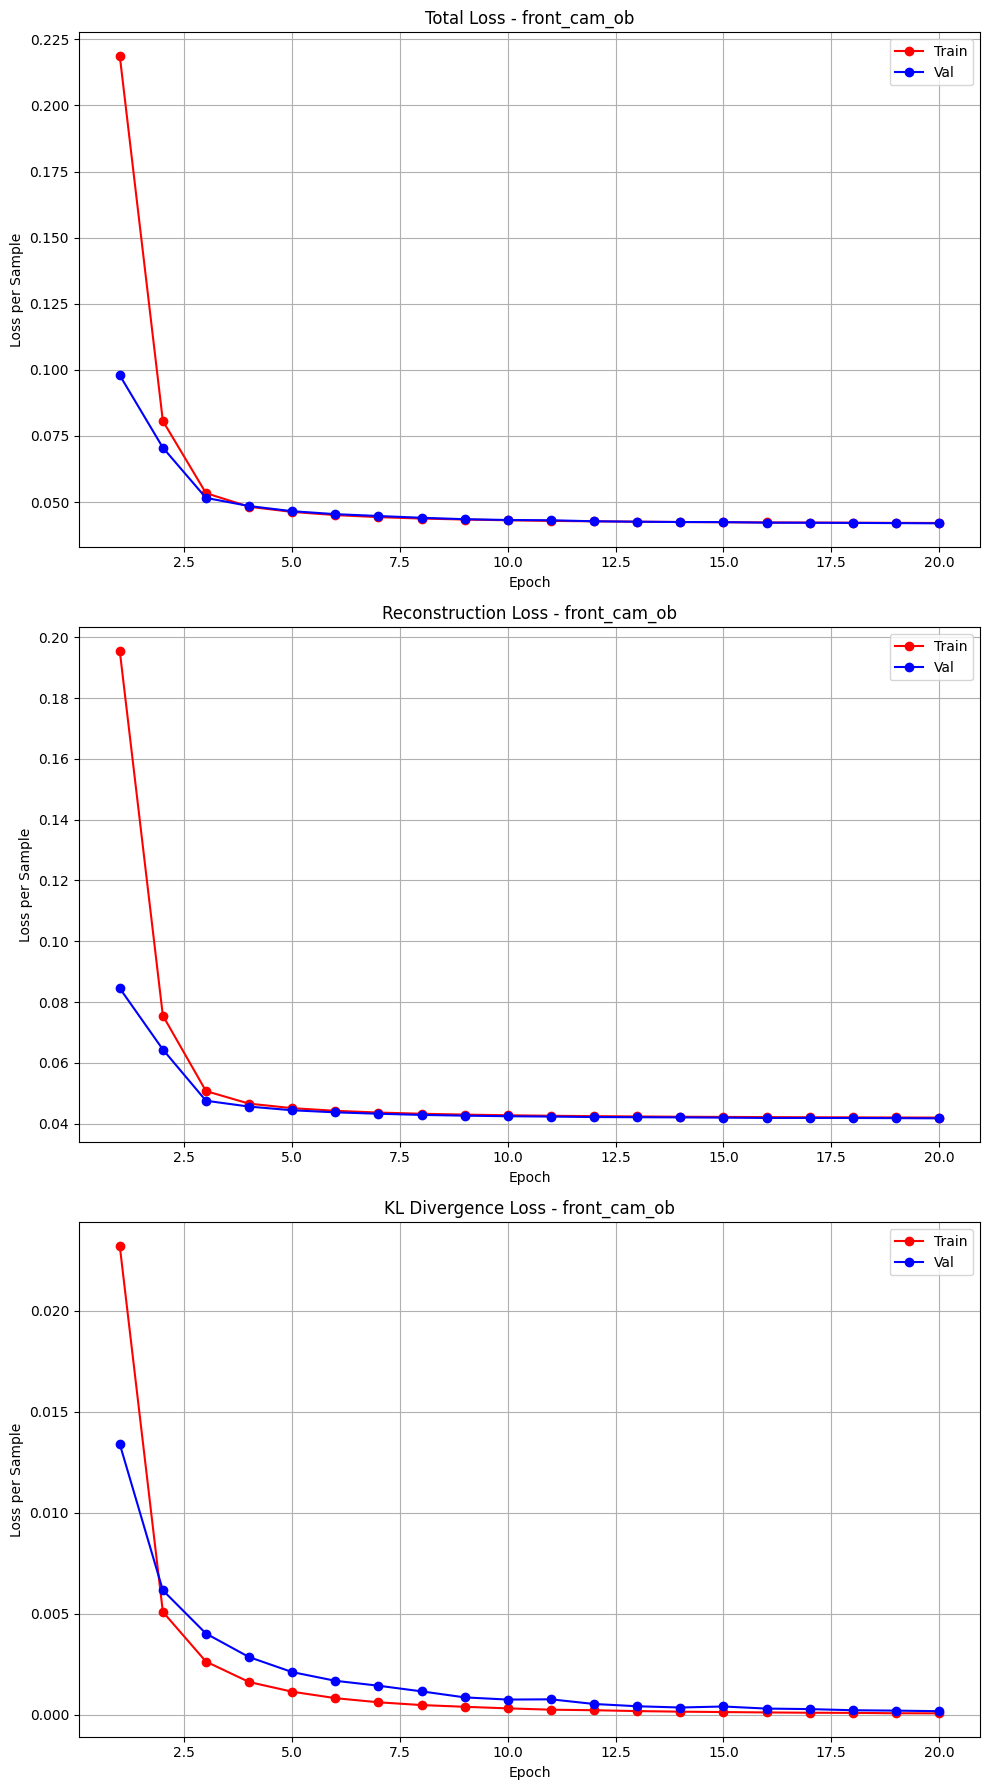

In [ ]:

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Total Loss
axs[0].plot(epochs, train_losses_front, "-ro", label="Train")
axs[0].plot(epochs, val_losses_front, "-bo", label="Val")
axs[0].set_title("Total Loss - front_cam_ob")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss per Sample')
axs[0].legend()
axs[0].grid(True)

# Reconstruction Loss
axs[1].plot(epochs, train_recon_losses_front, "-ro", label="Train")
axs[1].plot(epochs, val_reconstruction_losses_front, "-bo", label="Val")
axs[1].set_title("Reconstruction Loss - front_cam_ob")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss per Sample')
axs[1].legend()
axs[1].grid(True)

# KL Divergence Loss
axs[2].plot(epochs, train_KL_losses_front, "-ro", label="Train")
axs[2].plot(epochs, val_KL_losses_front, "-bo", label="Val")
axs[2].set_title("KL Divergence Loss - front_cam_ob")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss per Sample')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

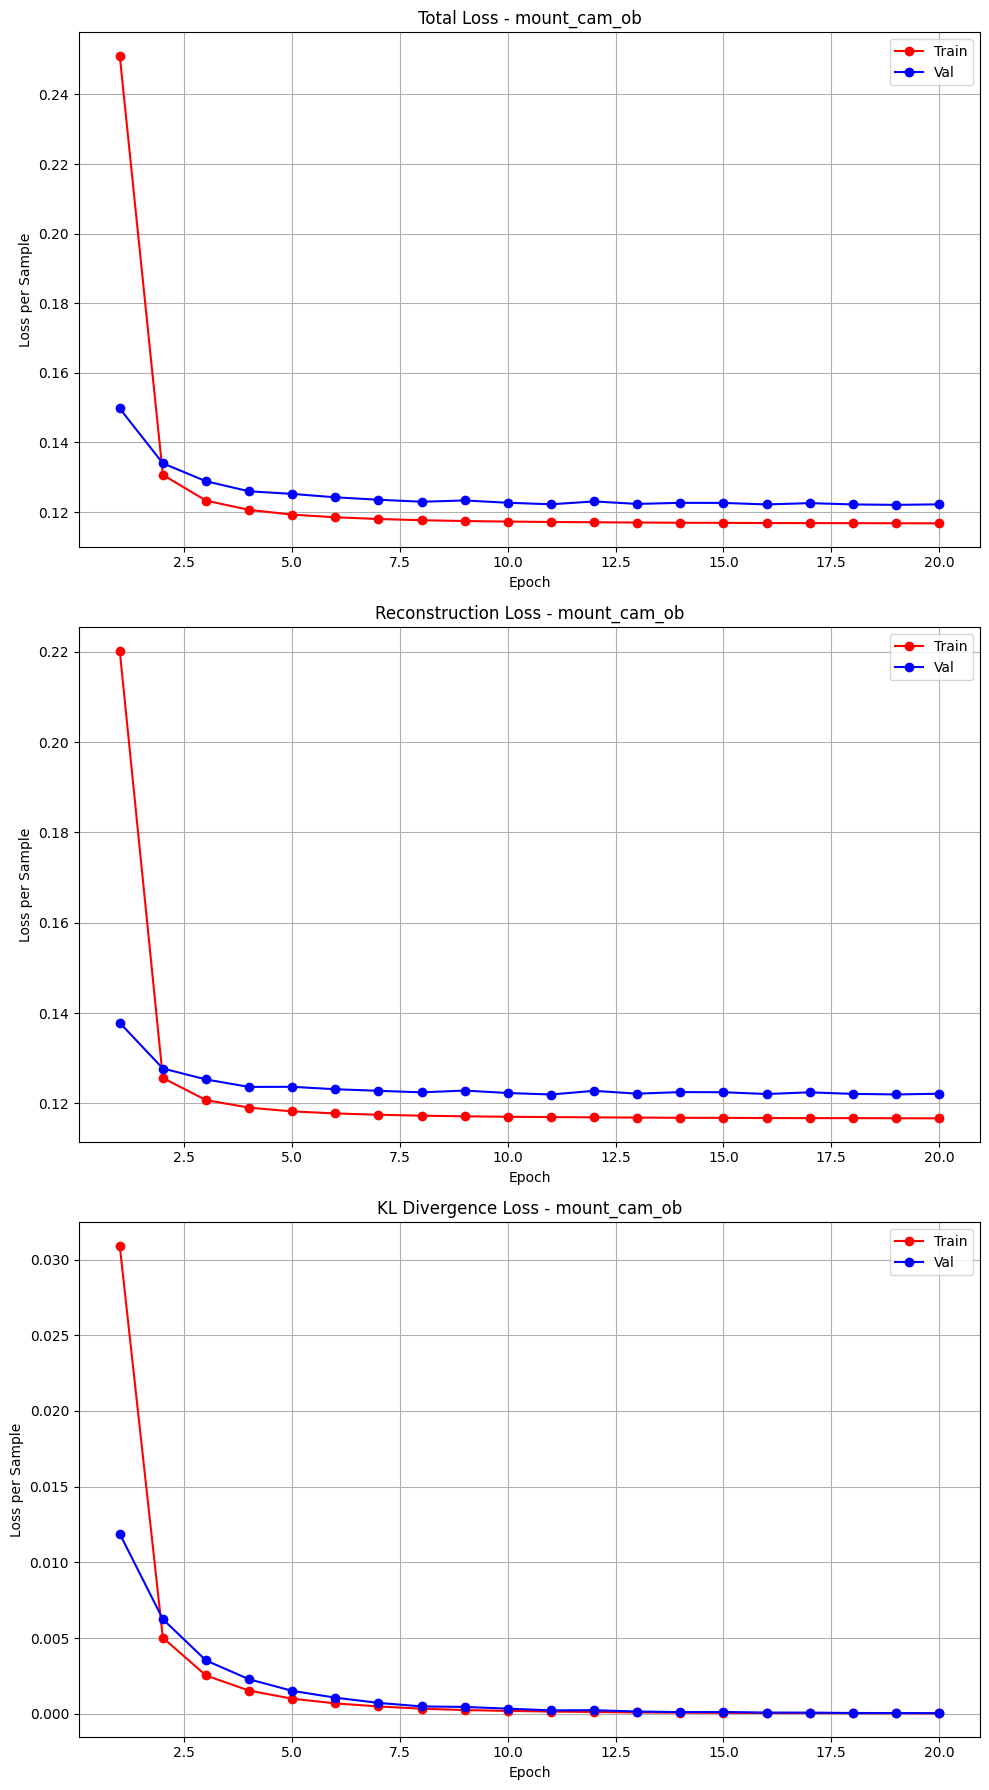

In [ ]:

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Total Loss
axs[0].plot(epochs, train_losses_mount, "-ro", label="Train")
axs[0].plot(epochs, val_losses_mount, "-bo", label="Val")
axs[0].set_title("Total Loss - mount_cam_ob")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss per Sample')
axs[0].legend()
axs[0].grid(True)

# Reconstruction Loss
axs[1].plot(epochs, train_recon_losses_mount, "-ro", label="Train")
axs[1].plot(epochs, val_reconstruction_losses_mount, "-bo", label="Val")
axs[1].set_title("Reconstruction Loss - mount_cam_ob")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss per Sample')
axs[1].legend()
axs[1].grid(True)

# KL Divergence Loss
axs[2].plot(epochs, train_KL_losses_mount, "-ro", label="Train")
axs[2].plot(epochs, val_KL_losses_mount, "-bo", label="Val")
axs[2].set_title("KL Divergence Loss - mount_cam_ob")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss per Sample')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Analysis of Convergence##

The code above trains independent VAE models on the 2 input images from the dataset: front_cam_ob and mount_cam_ob.

From the graphs above, convergence occurred in both VAE models. The graphs above show total loss, reconstruction loss and KL divergence loss for the respective image input variables.

Reconstruction loss measures how well the VAE can reconstruct the original input data from its latent representation. The front_cam_ob reconstruction plot showed a steady decrease in training and validation losses. Furthermore, training and validation losses converged to the same point - indicating a good fit. The mount_cam_ob reconstruction loss exhibited similar behaviour - decreasing steadily per epoch until converging to a minimum. Validation losses were only slighly higher than training losses.

KL divergence measaures the difference between the latent distribution and a prior distribution (which is a standard normal in this case). Its purpose is to encourage regularization and encourages the latent space to have a smooth distribution. KL divergence loss graphs across both variables indicate stability in training, as training and validation losses on both images converges steadily to the same point. In the code above, KL divergence shown has been multiplied by beta (0.2 in this case) as the aim was to prioritize reconstruction quality over regularization and the quality of the latent space. A lower beta does not strongly encourage the learned latent distribution to match the prior distribution. In spite of the low beta, KL divergence losses were low.

Total loss, which is a combination of reconstruction loss and KL divergence loss, also converged across both images. front_cam_ob loss had training and validation loss converge to the same point, while mount_cam_ob had its training loss slightly lower than validation loss. Both graphs indicate that overfitting did not occur. Total losses were smaller for mount_cam_ob than front_cam_ob (on both the training and validation set). This indicates that the VAE is better at modelling the mount_cam_ob images than the front_cam_ob images.



### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__.

## Analysis 1: Reconstruction Quality##

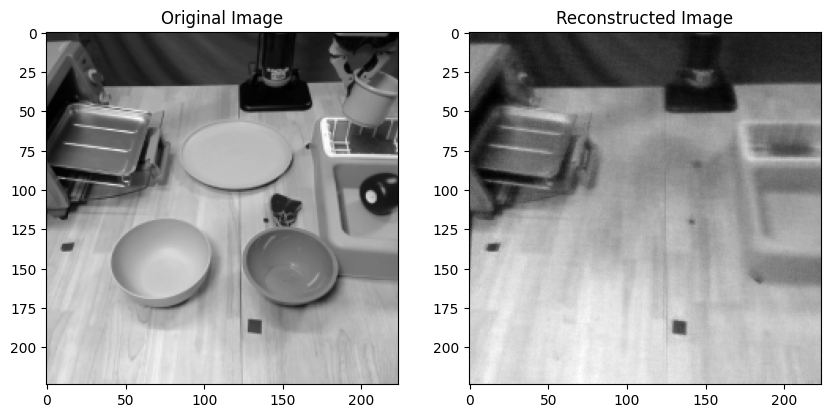

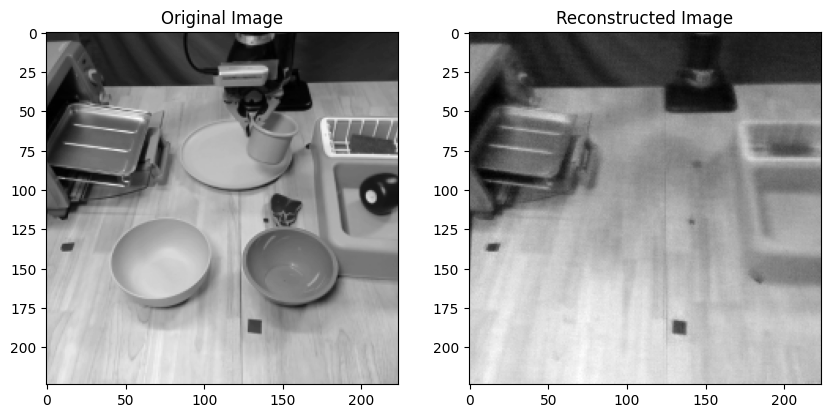

In [ ]:
for x in val_dataloader_vae_front:
    x = x[0].to(device)
    recon_x, mu, logvar = model_front(x)

    x_1 = x[0]
    recon_x_1 = recon_x[0]
    recon_x_1_np = recon_x_1.detach().cpu().permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x_1.cpu().permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(recon_x_1_np, cmap='gray')
    axs[1].set_title('Reconstructed Image')
    plt.show()

    x_2 = x[30]
    recon_x_2 = recon_x[30]
    recon_x_2_np = recon_x_1.detach().cpu().permute(1, 2, 0).numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x_2.cpu().permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(recon_x_2_np, cmap='gray')
    axs[1].set_title('Reconstructed Image')
    plt.show()




    break

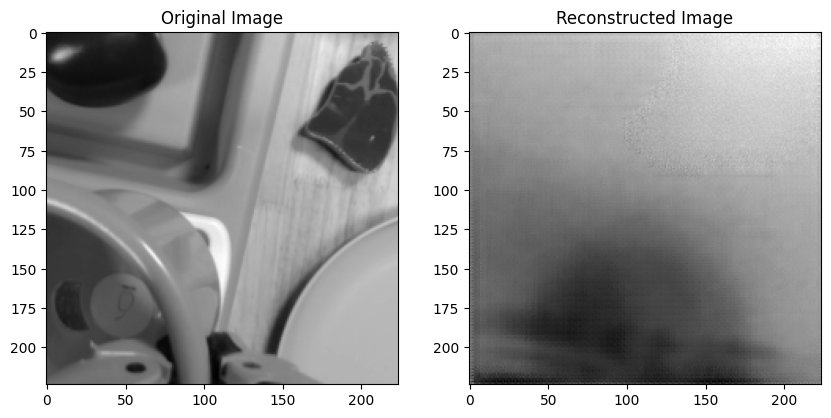

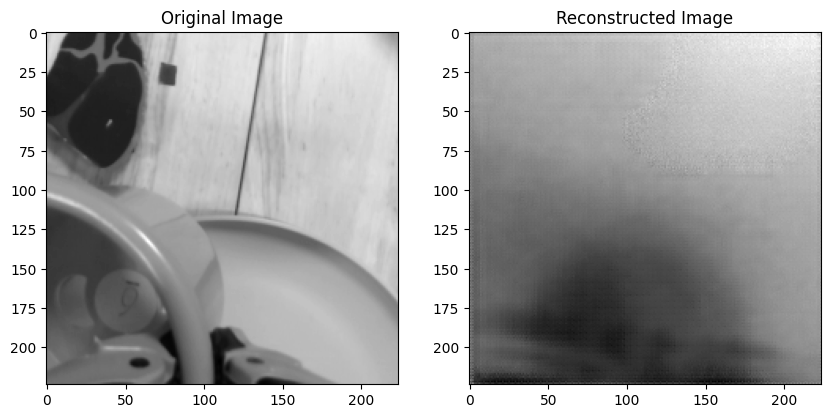

In [ ]:
for x in val_dataloader_vae_mount:
    x = x[0].to(device)
    recon_x, mu, logvar = model_mount(x)

    x_1 = x[0]
    recon_x_1 = recon_x[0]

    recon_x_1_np = recon_x_1.detach().cpu().permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x_1.cpu().permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(recon_x_1_np, cmap='gray')
    axs[1].set_title('Reconstructed Image')
    plt.show()

    x_2 = x[30]
    recon_x_2 = recon_x[30]
    recon_x_2_np = recon_x_1.detach().cpu().permute(1, 2, 0).numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x_2.cpu().permute(1, 2, 0), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(recon_x_2_np, cmap='gray')
    axs[1].set_title('Reconstructed Image')
    plt.show()

    break

## Analysis 2: Distribution of Latent Space Vectors ##

In [ ]:
latent_codes_front = []

for data in train_dataloader_vae_front:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_front.encode(data)
        z = model_front.reparameterize(mu, logvar).cpu().detach()
    latent_codes_front.append(z)

# Combine latent codes after all batches are processed
z_front = torch.cat(latent_codes_front, dim=0)

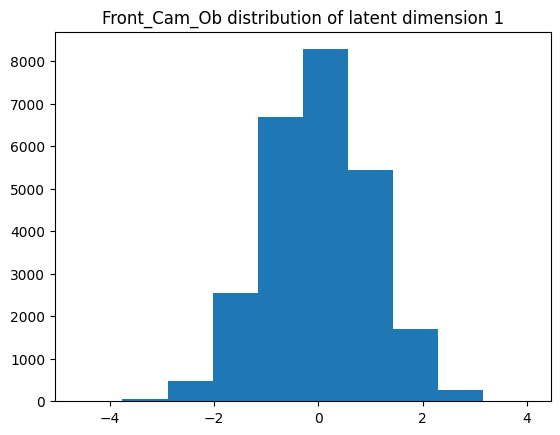

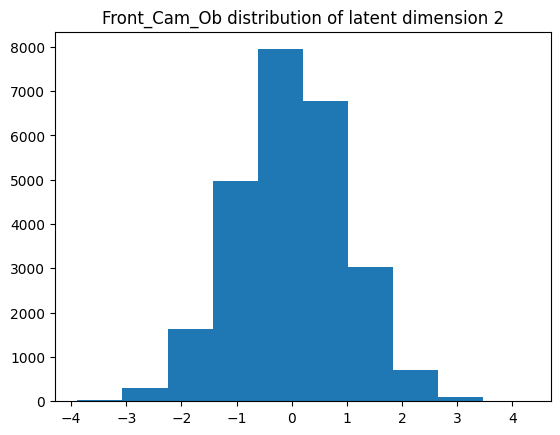

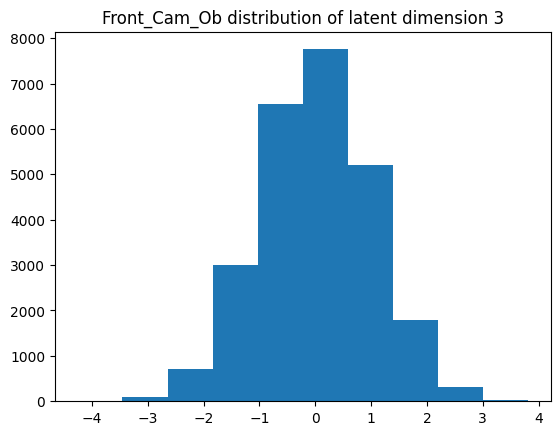

In [ ]:

for i in range(3):
  plt.hist(z_front[:, i])
  plt.title(f"Front_Cam_Ob distribution of latent dimension {i+1}")
  plt.show()

In [ ]:
latent_codes_mount = []

for data in train_dataloader_vae_mount:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_mount.encode(data)
        z = model_mount.reparameterize(mu, logvar).cpu().detach()
    latent_codes_mount.append(z)

# Combine latent codes after all batches are processed
z_mount = torch.cat(latent_codes_mount, dim=0)

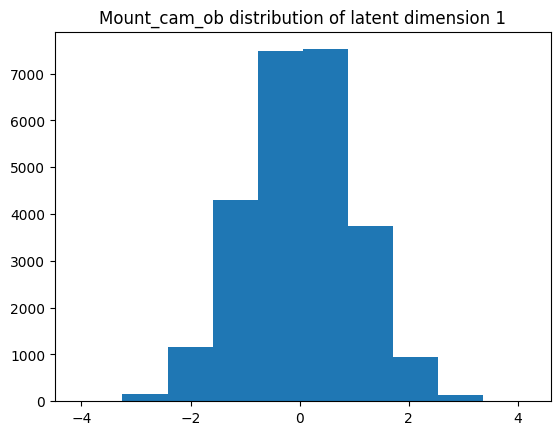

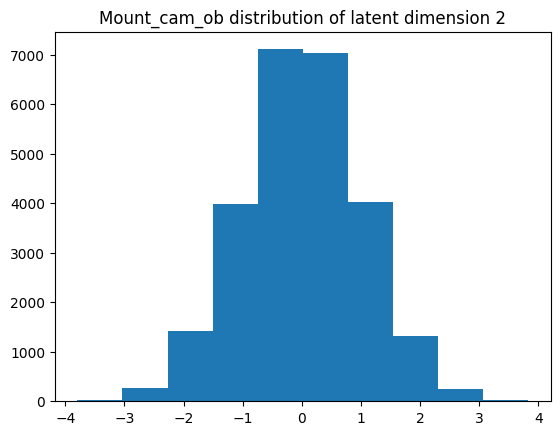

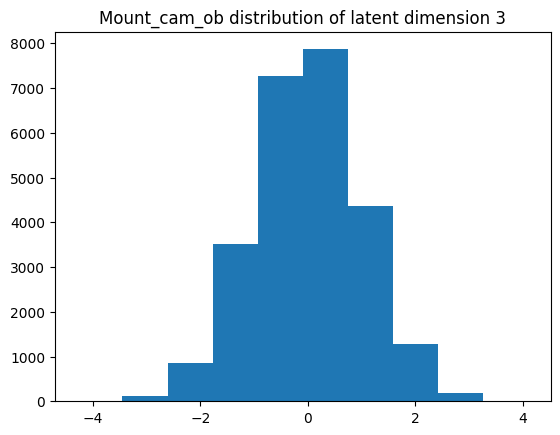

In [ ]:

for i in range(3):
  plt.hist(z_mount[:, i])
  plt.title(f"Mount_cam_ob distribution of latent dimension {i+1}")
  plt.show()

## Analysis 3: Correlation Between Latent Space Vectors ##

In [ ]:
correlation_matrix = np.corrcoef(z_front.T)
print("Correlation Matrix of front_cam_ob latent space")
print(correlation_matrix)

Correlation Matrix of front_cam_ob latent space
[[1.         0.00282387 0.00646274]
 [0.00282387 1.         0.0086717 ]
 [0.00646274 0.0086717  1.        ]]


In [ ]:
print("Correlation Matrix of front_cam_ob latent space")
correlation_matrix = np.corrcoef(z_mount.T)
print(correlation_matrix)

Correlation Matrix of front_cam_ob latent space
[[1.         0.01003351 0.00354901]
 [0.01003351 1.         0.00318509]
 [0.00354901 0.00318509 1.        ]]


Based on the analysis above, it appears as though the latent space may be beneficial for the downstream task.

Two VAEs were selected for this exercise - one for each of front_cam_on and mount_cam_ob. The VAEs had the same architecture.

Analysis 1 shows reconstruction quality. The reconstrcuted images for front_cam_ob captured the image quality fairly well however it left out certain features of the image - such as the plate. The reconstructed images for mount_cam_ob were blurry. The imperfections in the reconstructed images could either be due to lost information in the latent space (in this case, the encoder architecture or latent space dimensions should be changed) or the decoder model could not sufficiently reconstuct the image (in this case, the latent space contains much information that can be used in the downstream model - it is simply that the decoder cannot reconstruct the image). Nontheless, analysis 1 demonstrates that there are imperfections in the VAE. A simpler VAE had to be used for this task, with a stride parameter, as increasing the complexity of the VAE resulted in RAM issues.

Analysis 2 plots the distribution of vectors in the latent space. Each latent representation has a dimensionality of 3 (increasing the dimensionality lead to RAM issues). Distributions were approximately Normal for each vector. A low KL divergence loss in a VAE generally indicates that the learned distribution of the latent variables is close to the prior distribution. The prior distribution in this case was a standard Normal distribution. The Normal distribution of each variable in the latent space should simplify the downstream task.

Analysis 3 was inspired by the need for a disentngled representation of the data: https://deepai.org/machine-learning-glossary-and-terms/disentangled-representation-learning#:~:text=Disentangled%20representations%20aim%20to%20separate,data%20and%20how%20different%20factors

Analysis 3 shows correlation matrices between columns of the latent space. The correlation coefficients are low indicating that columns are independent of each other. This indicates that variables are disentangled and separate factors of variation are captured by separate variables. Disentangled representations aim to separate factors, making it easier for models to understand how different factors contribute to the data. Disentangled representations are easier for the model to understand and interpret. The low corelations indicate that the latent space is suitable for the downstream task.

### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [20]:
# Freeze model
model_front.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_front.to(device)

for param in model_front.image_encoder.parameters():
    param.requires_grad = False

In [21]:
# get latent space for front_cam_ob training data
latent_codes_front = []

for data in train_dataloader_vae_front:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_front.encode(data)
        z = model_front.reparameterize(mu, logvar).cpu().detach()
    latent_codes_front.append(z)

# Combine latent codes after all batches are processed
z_front = torch.cat(latent_codes_front, dim=0)

In [ ]:
z_front.shape

torch.Size([25469, 3])

In [22]:
# get latent space for front_cam_ob validaiton data

latent_codes_val_front = []

for data in val_dataloader_vae_front:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_front.encode(data)
        z_validation = model_front.reparameterize(mu, logvar).cpu().detach()
    latent_codes_val_front.append(z_validation)

# Combine latent codes after all batches are processed
z_validation_front = torch.cat(latent_codes_val_front, dim=0)

In [23]:
# use latent space data instead of original image data
del train_nps['front_cam_ob']

train_nps["front_cam_ob_latent"] = z_front


In [24]:
# use latent space data instead of original image data

del val_nps['front_cam_ob']

val_nps["front_cam_ob_latent"] = z_validation_front

In [25]:
# Same thing but for mount_cam_ob images
model_mount.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mount.to(device)

for param in model_mount.image_encoder.parameters():
    param.requires_grad = False

In [26]:
latent_codes_mount = []

for data in train_dataloader_vae_mount:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_mount.encode(data)
        z = model_mount.reparameterize(mu, logvar).cpu().detach()
    latent_codes_mount.append(z)

# Combine latent codes after all batches are processed
z_mount = torch.cat(latent_codes_mount, dim=0)

In [27]:
latent_codes_val_mount = []

for data in val_dataloader_vae_mount:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_mount.encode(data)
        z_validation = model_mount.reparameterize(mu, logvar).cpu().detach()
    latent_codes_val_mount.append(z_validation)

# Combine latent codes after all batches are processed
z_validation_mount = torch.cat(latent_codes_val_mount, dim=0)

In [28]:
del train_nps['mount_cam_ob']

train_nps["mount_cam_ob_latent"] = z_mount


In [29]:
del val_nps['mount_cam_ob']

val_nps["mount_cam_ob_latent"] = z_validation_mount

In [ ]:
train_nps.keys()
# the keys below show the new dataset

dict_keys(['actions', 'front_cam_ob', 'terminals', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob', 'mount_cam_ob_latent'])

In [ ]:
train_nps["mount_cam_ob_latent"].shape

torch.Size([25469, 3])

In [30]:
# DATA TRANSFORMATIONS
# All variables are now numerical

# Initialize the StandardScalers
pos_scaler = StandardScaler()
vel_scaler = StandardScaler()
joint_scaler = StandardScaler()
cam_scaler = StandardScaler()
cam2_scaler = StandardScaler()

pos_scaler.fit(train_nps['ee_cartesian_pos_ob'])
vel_scaler.fit(train_nps['ee_cartesian_vel_ob'])
joint_scaler.fit(train_nps['joint_pos_ob'])
cam_scaler.fit(train_nps['front_cam_ob_latent'])
cam2_scaler.fit(train_nps['mount_cam_ob_latent'])


global_transforms = {


    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: torch.tensor(pos_scaler.transform(x.reshape(1, -1)).squeeze()), # Reshape and squeeze
    "ee_cartesian_vel_ob": lambda x: torch.tensor(vel_scaler.transform(x.reshape(1, -1)).squeeze()),
    "joint_pos_ob": lambda x: torch.tensor(joint_scaler.transform(x.reshape(1, -1)).squeeze()),
    "front_cam_ob_latent": lambda x: torch.tensor(cam_scaler.transform(x.reshape(1, -1)).squeeze()),
    "mount_cam_ob_latent": lambda x: torch.tensor(cam2_scaler.transform(x.reshape(1, -1)).squeeze())


}

In [31]:

obs_encoder = MLP(
    input_dim = 21,
    hidden_dims = [ 256,256],
    output_dim = 128,
    actvton = nn.ReLU()

)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,64,32],
    output_dim = 6,
    actvton = nn.ReLU()

)

class Baseline1(BaseModel):

  def __init__(
      self,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self,  obs):
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]


    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model5 = Baseline1(
    obs_encoder=obs_encoder,
    dense=dense
)

In [32]:
torch.manual_seed(1)
model5.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.0001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        """images.append(
            torch.concat(
                [val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )"""
        val.input["front_cam_ob_latent"] = val.input["front_cam_ob_latent"].type(torch.float16)
        if val.input["front_cam_ob_latent"].dim() == 0:
            val.input["front_cam_ob_latent"] = val.input["front_cam_ob_latent"].unsqueeze(0)
        val.input["mount_cam_ob_latent"] = val.input["mount_cam_ob_latent"].type(torch.float16)
        if val.input["mount_cam_ob_latent"].dim() == 0:
            val.input["mount_cam_ob_latent"] = val.input["mount_cam_ob_latent"].unsqueeze(0)
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"],
                    val.input["front_cam_ob_latent"],
                    val.input["mount_cam_ob_latent"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            #"images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

#input_dim = first_batch.input["images"].shape
#print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model5.__repr__()


if exp_kwargs["half_precision"]:
    model5 = model5.half()
optimizer = torch.optim.Adam(
    model5.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04, weight_decay =0.01
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model5 = model5.cuda()
            with torch.autocast(device_type="cuda"):
                res = model5(
                    #images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model5(
                    #images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model5 = model5.cuda()
            res = model5(
                #images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model5(
                #images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))

25469
torch.Size([64, 21])
torch.Size([64, 3])
torch.Size([64, 3])
tensor(1.1289, device='cuda:0', dtype=torch.float16)


In [35]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model5, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=20, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    #preds_save_type=None
    preds_save_type='csv', output_dir='./output'
)

wandb_name = "End_to_end_1_improvement5"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

INFO:cw2_logger:Running epochs: 20
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [00:43<00:00,  9.24it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.5771484375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.421875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [00:42<00:00,  9.33it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.37841796875
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.369140625 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [00:42<00:00,  9.28it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.349365234375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.352294921875 
INFO:cw2_logger:Running training epoch
100%|██████████| 398/398 [00:42<00:00,  9.42it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.33984375
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validation loss : 0.348876953125 
INFO:cw2_logger:Running t

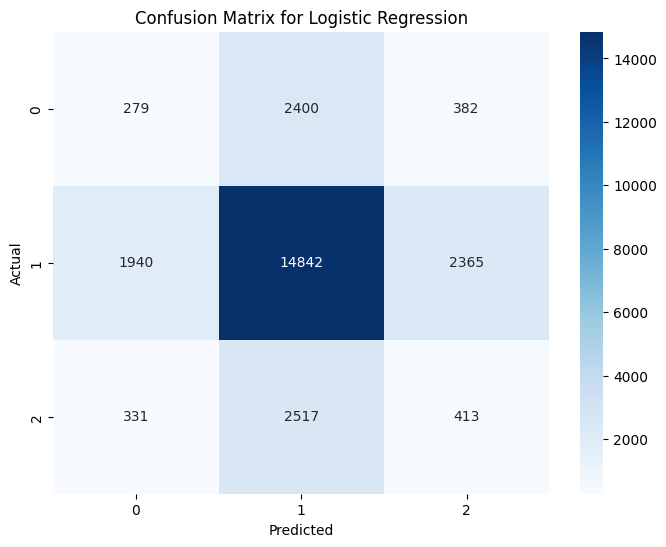

Overall Accuracy: 0.61
Class-wise Accuracies:
Class 0: 0.09
Class 1: 0.78
Class 2: 0.13


In [ ]:
data_path_grp_tr = "/content/output/epoch_10_train_preds_grp.csv"

grp_data_tr = pd.read_csv(data_path_grp_tr, header = None)

# extract column 4 from train_nps['actions']
actual_grp_tr = train_nps['actions'][:,3]
argmax_grp_tr = grp_data_tr.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_tr, argmax_grp_tr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_tr, argmax_grp_tr)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

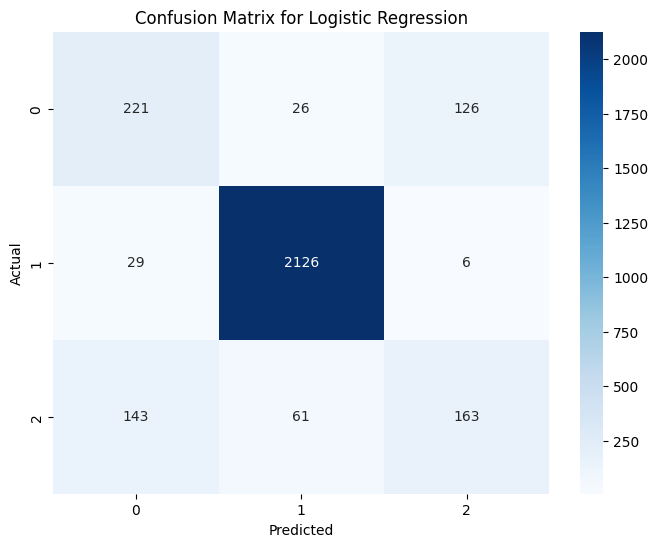

Overall Accuracy: 0.87
Class-wise Accuracies:
Class 0: 0.59
Class 1: 0.98
Class 2: 0.44


In [ ]:
data_path_grp_val = "/content/output/epoch_10_val_preds_grp.csv"
grp_data_val = pd.read_csv(data_path_grp_val, header = None)

# extract column 4 from train_nps['actions']
actual_grp_val = val_nps['actions'][:,3]
argmax_grp_val = grp_data_val.idxmax(axis=1)


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_val, argmax_grp_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_val, argmax_grp_val)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

### Question 3.b Assessing the suitability of self-supervised learning
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks)

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [36]:
# ******* INSERT YOUR CODE HERE *******

#Load the test data

_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
test_nps = load_all_files(test_dh.loc,"test_[0-9]+.h5",keys=_keys)


# ******* INSERT YOUR CODE HERE - END *******

100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


In [42]:
# convert test data to dataloader form
if exp_kwargs["half_precision"]:
    test_dataset = NpDictDataset(
        array_dict=test_nps,
        transform_lkp = global_transforms, #ensure that global transforms from QUESTION 1 is run
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

else:
    test_dataset = NpDictDataset(
        array_dict={k:test_nps[k].astype(np.float32) for k in test_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


test_dataloader = DataLoader(
    test_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

In [86]:
# Analyze final model from Q1 on the test set
import wandb

mo = WandBMetricOrchestrator()

test_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="test",
    mo=mo
    )

wandb.init(project=WANDB_PROJECT, group="End_to_end", name="End_to_end_1_test")
grp_pred_test = []
test_losses = 0
grp_losses = 0
pos_losses = 0
count = 0
for batch in test_dataloader:
  with torch.no_grad():
    images = batch.input["images"].cuda().half()
    obs = batch.input["obs"].cuda().half()
    model_final = model_final.cuda()
    model_final = model_final.half()
    res = model_final(
        images=images,
        obs=obs
        )
    batch.output["pos"] = batch.output["pos"].cuda().half()
    batch.output["grp"] = batch.output["grp"].cuda().half()
    test_losses += test_criterion(res,batch.output)
    grp_losses += grp_criterion(res["grp"],batch.output["grp"])
    pos_losses += pos_criterion(res["pos"],batch.output["pos"])
    count += 1
    grp_pred_test.append(torch.argmax(res["grp"], dim=1).cpu().numpy())
print("Question 1 Model Test Loss: ",test_losses.item()/len(test_dataloader))
print("Final grp loss : ",grp_losses.item()/len(test_dataloader))
print("Final pos loss : ",pos_losses.item()/len(test_dataloader))




Question 1 Model Test Loss:  0.39402173913043476
Final grp loss :  0.38668478260869565
Final pos loss :  0.00770210597826087


In [98]:
grp_pred_test = [item for sublist in grp_pred_test for item in sublist]


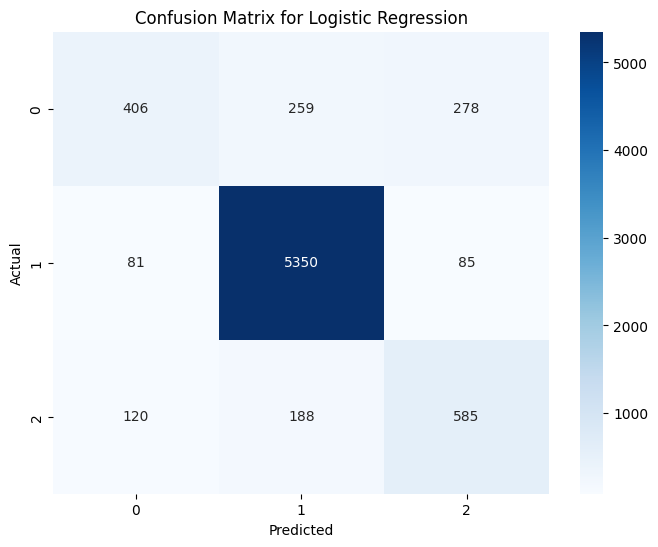

Overall Accuracy: 0.86
Class-wise Accuracies:
Class 0: 0.43
Class 1: 0.97
Class 2: 0.66


In [99]:

# extract column 4 from test_nps['actions']
actual_grp_te = test_nps['actions'][:,3]
argmax_grp_te = grp_pred_test


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_te, argmax_grp_te)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_te, argmax_grp_te)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

In [43]:
# The code below will be used to analyze the combined model on the test set
# test data needs to be passed through the VAEs so that we obtain latent representations of the image data
# appropriate transformations then need to be done

batch_size = 32

test_dataset_vae_front  = NpDictDataset(
       array_dict=test_nps,
       transform_lkp=global_transforms, #same transform as Q1
       dep_vars=[],
       indep_vars=["front_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )
def custom_collate(batch):
    data = [item.input["front_cam_ob"] for item in batch]
    return torch.stack(data) ,torch.empty(len(data))


test_dataloader_vae_front  = DataLoader(
       test_dataset_vae_front,
       shuffle=False,
       batch_size=batch_size,
       collate_fn=custom_collate

   )

test_dataset_vae_mount  = NpDictDataset(
       array_dict=test_nps,
       transform_lkp=global_transforms, #same transform as Q1
       dep_vars=[],
       indep_vars=["mount_cam_ob"],
       target_offset=exp_kwargs["target_offset"]
   )

def custom_collate(batch):
    data = [item.input["mount_cam_ob"] for item in batch]
    return torch.stack(data) ,torch.empty(len(data))

test_dataloader_vae_mount  = DataLoader(
       test_dataset_vae_mount,
       shuffle=False,
       batch_size=batch_size,
       collate_fn=custom_collate

   )

In [44]:
model_front.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_front.to(device)

for param in model_front.image_encoder.parameters():
    param.requires_grad = False



In [45]:
latent_codes_front = []

for data in test_dataloader_vae_front:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_front.encode(data)
        z = model_front.reparameterize(mu, logvar).cpu().detach()
    latent_codes_front.append(z)

# Combine latent codes after all batches are processed
z_front = torch.cat(latent_codes_front, dim=0)

In [46]:
z_front.shape

torch.Size([7352, 3])

In [47]:
del test_nps['front_cam_ob']

test_nps["front_cam_ob_latent"] = z_front

In [48]:
model_mount.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mount.to(device)

for param in model_mount.image_encoder.parameters():
    param.requires_grad = False  # Freeze the encoder weights

In [49]:
latent_codes_mount = []

for data in test_dataloader_vae_mount:
    data = data[0].to(device)
    with torch.no_grad():
        mu, logvar = model_mount.encode(data)
        z = model_mount.reparameterize(mu, logvar).cpu().detach()
    latent_codes_mount.append(z)

# Combine latent codes after all batches are processed
z_mount = torch.cat(latent_codes_mount, dim=0)

In [50]:
del test_nps['mount_cam_ob']

test_nps["mount_cam_ob_latent"] = z_mount

In [108]:
test_nps.keys()

dict_keys(['actions', 'terminals', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob', 'front_cam_ob_latent', 'mount_cam_ob_latent'])

In [51]:
# Transforms as in Q2
pos_scaler = StandardScaler()
vel_scaler = StandardScaler()
joint_scaler = StandardScaler()
cam_scaler = StandardScaler()
cam2_scaler = StandardScaler()


pos_scaler.fit(train_nps['ee_cartesian_pos_ob'])
vel_scaler.fit(train_nps['ee_cartesian_vel_ob'])
joint_scaler.fit(train_nps['joint_pos_ob'])
# if error, re-run the train_nps and then VAE code in Q3a
cam_scaler.fit(train_nps['front_cam_ob_latent'])
cam2_scaler.fit(train_nps['mount_cam_ob_latent'])


global_transforms = {


    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: torch.tensor(pos_scaler.transform(x.reshape(1, -1)).squeeze()), # Reshape and squeeze
    "ee_cartesian_vel_ob": lambda x: torch.tensor(vel_scaler.transform(x.reshape(1, -1)).squeeze()),
    "joint_pos_ob": lambda x: torch.tensor(joint_scaler.transform(x.reshape(1, -1)).squeeze()),
    "front_cam_ob_latent": lambda x: torch.tensor(cam_scaler.transform(x.reshape(1, -1)).squeeze()),
    "mount_cam_ob_latent": lambda x: torch.tensor(cam2_scaler.transform(x.reshape(1, -1)).squeeze())


}

In [52]:
# evaluate model on test set
if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    test_dataset = NpDictDataset(
        array_dict=test_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )


else:
    test_dataset = NpDictDataset(
        array_dict={k:test_nps[k].astype(np.float32) for k in test_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
             "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob", "front_cam_ob_latent", "mount_cam_ob_latent"
            ],
        target_offset=exp_kwargs["target_offset"]
        )



def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        """images.append(
            torch.concat(
                [val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )"""
        val.input["front_cam_ob_latent"] = val.input["front_cam_ob_latent"].type(torch.float16)
        if val.input["front_cam_ob_latent"].dim() == 0:
            val.input["front_cam_ob_latent"] = val.input["front_cam_ob_latent"].unsqueeze(0)
        val.input["mount_cam_ob_latent"] = val.input["mount_cam_ob_latent"].type(torch.float16)
        if val.input["mount_cam_ob_latent"].dim() == 0:
            val.input["mount_cam_ob_latent"] = val.input["mount_cam_ob_latent"].unsqueeze(0)
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"],
                    val.input["front_cam_ob_latent"],
                    val.input["mount_cam_ob_latent"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            #"images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func
)




In [55]:
import wandb

mo = WandBMetricOrchestrator()

test_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="test",
    mo=mo
    )

wandb.init(project=WANDB_PROJECT, group="End_to_end", name="End_to_end_1_testVAE")
grp_pred_test = []
test_losses = 0
grp_losses = 0
pos_losses = 0
count = 0
for batch in test_dataloader:
  with torch.no_grad():
    obs = batch.input["obs"].cuda().half()
    model5 = model5.cuda()
    model5 = model5.half()
    res = model5(
        obs=obs
        )
    batch.output["pos"] = batch.output["pos"].cuda().half()
    batch.output["grp"] = batch.output["grp"].cuda().half()
    test_losses += test_criterion(res,batch.output)
    grp_losses += grp_criterion(res["grp"],batch.output["grp"])
    pos_losses += pos_criterion(res["pos"],batch.output["pos"])
    count += 1
    grp_pred_test.append(torch.argmax(res["grp"], dim=1).cpu().numpy())
print("Final Combined Model : ",test_losses.item()/len(test_dataloader))
print("Final grp loss : ",grp_losses.item()/len(test_dataloader))
print("Final pos loss : ",pos_losses.item()/len(test_dataloader))


Final Combined Model :  0.3353260869565217
Final grp loss :  0.33016304347826086
Final pos loss :  0.005719259510869565


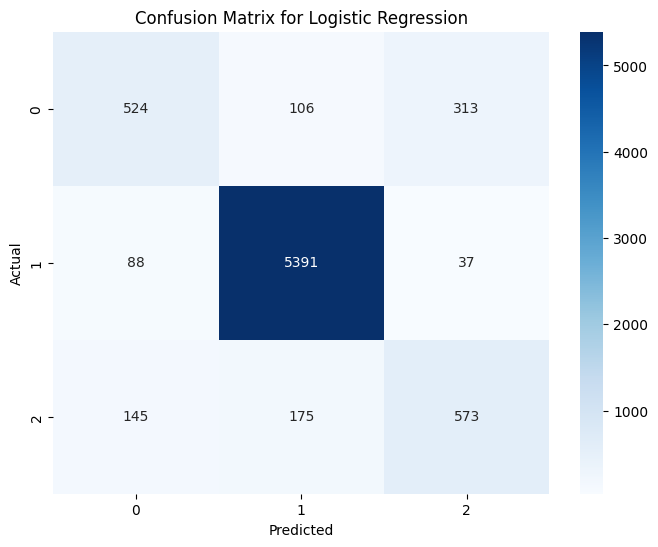

Overall Accuracy: 0.88
Class-wise Accuracies:
Class 0: 0.56
Class 1: 0.98
Class 2: 0.64


In [56]:
grp_pred_test = [item for sublist in grp_pred_test for item in sublist]

# extract column 4 from test_nps['actions']
actual_grp_te = test_nps['actions'][:,3]
argmax_grp_te = grp_pred_test


# Calculate the confusion matrix
cm = confusion_matrix(actual_grp_te, argmax_grp_te)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_grp_te, argmax_grp_te)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Calculate class-wise accuracy
num_classes = cm.shape[0]
class_accuracies = []
for i in range(num_classes):
    true_positives = cm[i, i]
    total_samples = sum(cm[i, :])
    class_accuracy = true_positives / total_samples
    class_accuracies.append(class_accuracy)

print("Class-wise Accuracies:")
for i, accuracy in enumerate(class_accuracies):
    print(f"Class {i}: {accuracy:.2f}")

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.

## Summary of Losses ##

**Final Model from Question 1**

Question 1 Model Test Loss:  0.39402173913043476

Final grp loss :  0.38668478260869565

Final pos loss :  0.00770210597826087



**Self Supervised VAE with Downstream Model**

Final Combined Model :  0.3353260869565217

Final grp loss :  0.33016304347826086

Final pos loss :  0.005719259510869565

## Accuracy on the Test Set ##

**Final Model from Question 1**

Overall Accuracy: 0.86

Class-wise Accuracies:

Class 0: 0.43

Class 1: 0.97

Class 2: 0.66

**Self Supervised VAE with Downstream Model**

Overall Accuracy: 0.88

Class-wise Accuracies:

Class 0: 0.56

Class 1: 0.98

Class 2: 0.64


## Analysis of Loss ##

Based on test set performance, the combined model (with self-supervised pre-training) was better in predicting actions. The overall loss on the test set was lower than the model trained in Question 1. Furthermore, individual losses on the gripper action and position were both lower under the combined model. This shows that the combined model's lower losses were not driven by superior performance in just one of the predictions, but rather by superior performance in both predictions.

The combined model also had superior performance on the validation set (loss was 0.33544921875 whereas on the model from Question 1, validation loss was 0.379150390625). Training loss on the combined model was also lower (0.3056640625) than the model from Q1 (0.310791015625).

Lower losses on the combined model were achieved on each of the training set, validation set and test set - hence the combined model is better at predicting actions and better at generalizing to unseen data.

## Analysis of Accuracy##

The combined model had slightly better overall accuracy (improving from 0.86 to 0.88). Accuracy on class 0 improved from 0.43 to 0.56. Both models still produced bias towards class 1 - achieving high accuracy on the majority class but lower accuracy on the minority classes. When comparing accuracies on the validation set, the combined model performed slightly better (from 0.86 to 0.87).

## Other Considerations ##
Training a combined model is more complicated as VAE models need to be trained indepdently on the image variables. First VAE's need to be trained and then used to ascribe a latent representation of the image variables. In this case, convergence of the VAEs occurred around 10 epochs, with only slight improvements occurring in epochs 11-20.

The combined model converged within 10 epochs as well. After epoch 10, validation losses did not improve and hovered around 0.335. Hence both models converged within 10 epochs, however the combined model involves 3 models (2 VAEs and 1 Downstream model) which adds more time and computing resources.

The VAEs were able to convert images into a latent representation of 3 dimensions (there may have been some information loss in doing so). This makes the downstream model simpler, as there is no need for CNN components in the downstream model, and there is no need to combine CNNs and outputs with numerical variables. The latent representations were combined with other numerical input variables and these were fed through a MLP.

It may not have been fair to compare the Q1 model with the downstream combined model. The Q1 model architecture was slightly more complicated due to the presence of CNNs - hence the model would have more parameters (as it was essentially a combination of CNNs and MLPs). The downstream model is simpler (only MLPs). This difference in model complexity creates an unfair advantage for the Q1 model, as it has more capacity to learn and represent complex patterns. To make comparison fairer, perhaps the downstream model could have had a wider or deeper MLP to compensate that there is no CNN. Overall the combined model was able to produce better performance, despite fewer model parameters.

Further experiments include hyperparameter tuning and changing the architecture of the models so that they arae more equal in complexity.

In order to reduce bias in prediction (where the model has a preference for the majority class and thus achieves lower accuracy on minority classes), techniques like a weighted random sampler, oversampling or undersampling can be usedn to address class imbalance in the training data and hopefully lead to high accuracy on all 3 classes.
